VENUS NOTEBOOK TAKE 2

In [1]:
using Revise
using PyPlot
using PyCall
using HDF5
using DataFrames
using Interpolations 
using DelimitedFiles
using XLSX
using Printf
photochemistry_source_dir = "$(@__DIR__)/Photochemistry/src/"
println("loading Photochemistry.jl from $photochemistry_source_dir")
push!(LOAD_PATH, photochemistry_source_dir)
using Photochemistry  # custom module
using QuadGK
import Base.@kwdef
using GeneralizedGenerated

loading Photochemistry.jl from /home/mike/Documents/Proposals/2023_Venus_H/ion_model/VenusPhotochemistry/Photochemistry/src/


In [2]:
include("CUSTOMIZATIONS.jl");
include("CONSTANTS.jl");

# Functions

In [3]:
function plot_ion_ranges_wide_2panel(ions_to_plot, simfolder, savepath;
                          comparison_ions=[:CO2pl, :O2pl, :Opl], showonly=false, extra_fn="", xL = [1e-7, 1e7],
                          posdict = Dict(:ArDpl => [8e-7, 190], :Dpl => [3e-3, 260], :DCOpl => [0.7, 175], :DOCpl => [2e-5, 260], :DCO2pl => [1.5e-2, 150], 
                                         :HDOpl => [2e-4, 260], :H2DOpl => [1e-3, 100], :HDpl => [1e-6, 150], 
                                         :H2Dpl => [2e-6, 260], :N2Dpl => [3e-4, 145], :ODpl => [6e-3, 240],
                                         :ArHpl => [3e-6, 210], :Hpl => [1.7e-4, 220], :HCOpl => [9e-2, 175], :HOCpl => [1.5e-5, 230], :HCO2pl => [1.5e-3, 150],
                                         :H2Opl => [1e-3, 175], :H3Opl => [1.7e-5, 235], :H2pl => [8e-4, 235], 
                                         :H3pl => [3e-6, 240], :N2Hpl => [1e-3, 165], :OHpl => [6e-4, 210],
                                         :CO2pl => [1e3, 130], :O2pl => [2e3, 240], :Opl => [15, 135],))


    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 16
    rcParams["axes.titlesize"] = 18
    rcParams["axes.labelsize"]= 16
    rcParams["xtick.labelsize"] = 16
    rcParams["ytick.labelsize"] = 16
    rcParams["lines.linewidth"] = 1
    
    # Load the 3 atmospheres
    ncur = get_ncurrent(simfolder*"final_atmosphere.h5")

    # set up the overall plot -------------------------------------------------------------
    ncol = 1
    nrow = 2
    fig, ax = subplots(nrow, ncol, figsize=(16,10), gridspec_kw=Dict("height_ratios"=>[1,1], "hspace"=>0.06))
    ax[1].set_title("Ion densities in detail")
    ax[nrow].set_xlabel(L"Number density (cm$^{-3}$)")
    
    for a in ax
        plot_bg(a)
        a.tick_params(which="both", labeltop=false, top=true, labelbottom=false, bottom=true, labelleft=true)
        a.set_ylim(80, zmax/1e5)
        a.set_yticks(100:50:zmax/1e5)
        a.set_xscale("log")
        a.set_xlim(xL[1], xL[2])
        a.set_ylabel("Altitude (km)")
    end
    
    # Set the right limit to 2e5 for just the solar mean plot with D ions since we need to show the comparisons
    ax[1].set_xlim(right=xL[2])
    ax[2].set_xlim(right=xL[2])
    
    # These have to go here to override the previous setting
    ax[1].tick_params(which="both", labeltop=true)
    ax[nrow].tick_params(which="both", labelbottom=true)
    
    # plot the ions according to logical groups ------------------------------------------------------------
    lineorder = Dict([i=>4 for i in comparison_ions])

    for ion in ions_to_plot
        row = occursin("D", string(ion)) ? 2 : 1  # set column based on ion

        # style things
        thiscolor = get(speciescolor, ion, dimcolor)
        this_zorder = 10

        # Axes showing range of values
        ax[row].plot(ncur[ion], plot_grid, color=thiscolor, linewidth=2, label=ion, zorder=this_zorder)
        ax[row].text(posdict[ion]..., string_to_latexstr(string(ion)), color=thiscolor, va="top", transform=ax[row].transAxes)
    end

    # Plot comparison ions
    for comp_ion in comparison_ions
        for i in 1:nrow
            if i < 3
                position = posdict[comp_ion]
            else 
                position = posdict[comp_ion]
            end
            
            ax[i].plot(ncur[comp_ion], plot_grid, color=dimcolor,
                          linewidth=2, label=comp_ion, zorder=get(lineorder, comp_ion, 10))
            ax[i].text(position..., string_to_latexstr(string(comp_ion)), color=get(speciescolor_forDions, comp_ion, dimcolor), va="top", zorder=15,  transform=ax[i].transAxes)
        end
    end

    
    # Indicate H and D species
    fs = 34
    ax[1].text(0.9, 0.9, "H ions", color="#696969", fontsize=fs, va="top", transform=ax[1].transAxes)
    ax[2].text(0.9, 0.9, "D ions", color="#696969", fontsize=fs, va="top", transform=ax[2].transAxes)
    
    # Show and save
    if showonly==false
        savefig(savepath*"H_and_D_ions$(extra_fn)_wide.png", bbox_inches="tight", dpi=300)
    end
    show()
end


plot_ion_ranges_wide_2panel (generic function with 1 method)

# Load and set folders

In [4]:
# In case results dir is different in the file (running simulations for other paper)
results_dir = code_dir*"../Results/"

all_result_plot_folder = "$(@__DIR__)/../Results/FirstLook_Plots/"

"/home/mike/Documents/Proposals/2023_Venus_H/ion_model/VenusPhotochemistry/../Results/FirstLook_Plots/"

In [5]:
#mean_folder = results_dir*"I-Ts735Tm170Te290-W1e-6-Smean_c1JKkl1M_venus_initial_convergence_v0.7/"  # fixed BC sign convention, Ar transport
mean_folder = results_dir*"I-Ts735Tm170Te290-W1e-6-Smean_9yCawIou_venus_initial_convergence_v0.7/"  # fixed temps
mean_folder = results_dir*"I-Ts735Tm170Te290-W1e-6-Smean_n8eMVDoI_venus_initial_convergence_v0.7/"  # doubled HDO/H2O at lower boundary
mean_atm = get_ncurrent(mean_folder*"/final_atmosphere.h5");

vardict = load_from_paramlog(mean_folder);

ions_included = vardict["ions_included"];
neutral_species = vardict["neutral_species"];
ion_species  = vardict["ion_species"];
all_species = vardict["all_species"];
rxn_spreadsheet = vardict["rxn_spreadsheet"];

Tn = vardict["Tn_arr"];
Ti = vardict["Ti_arr"];
Te = vardict["Te_arr"];
Tplasma = vardict["Tplasma_arr"];
Tprof_for_Hs = vardict["Tprof_for_Hs"];
Tprof_for_diffusion = vardict["Tprof_for_diffusion"];
Hs_dict = vardict["Hs_dict"];
speciesbclist = vardict["speciesbclist"];
transport_species = vardict["transport_species"];

rshortcode = vardict["rshortcode"]
hrshortcode = vardict["hrshortcode"]

"n8eMVDoI"

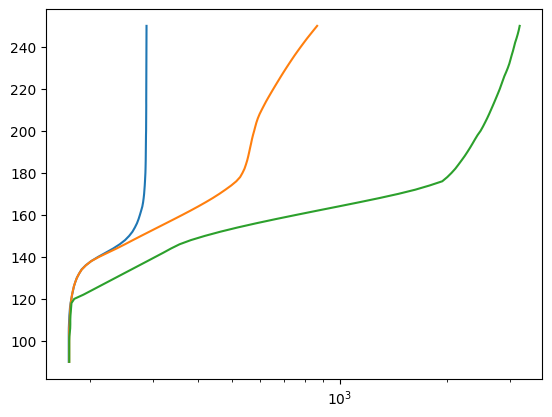

In [6]:
fig, ax_temp = subplots(1)

ax_temp.plot(Tn, alt/1e5)
ax_temp.plot(Ti, alt/1e5)
ax_temp.plot(Te, alt/1e5)
ax_temp.set_xscale("log")

In [7]:
Tn[end]

287.47814474034067

In [8]:
D_ions = [s for s in ion_species if occursin('D', string(s))];
D_H_analogues = Dict(:ArDpl=>:ArHpl, :Dpl=>:Hpl, :DCOpl=>:HCOpl, :HDpl=>:H2pl, :HD2pl=>:H3pl, :H2Dpl=>:H3pl, :N2Dpl=>:N2Hpl,
                           :DCO2pl=>:HCO2pl, :DOCpl=>:HOCpl, :H2DOpl=>:H3Opl, :HDOpl=>:H2Opl, :ODpl=>:OHpl);
D_bearing_species = [s for s in setdiff(union(neutral_species, ion_species), [:O1D, :Nup2D]) if occursin('D', string(s))];
speciesstyle = Dict(vcat([s=>"--" for s in setdiff(D_bearing_species, [:HD2pl])], [:HD2pl=>":", :Nup2D=>"-."]) );

global speciescolor_forDions = Dict([ion=>speciescolor[ion] for ion in keys(D_H_analogues)])
# speciescolor_forDions[:H3Opl] = speciescolor[:H3Opl]

dimcolor = "xkcd:greyish"

"xkcd:greyish"

# Atmosphere plots

## Whole atm

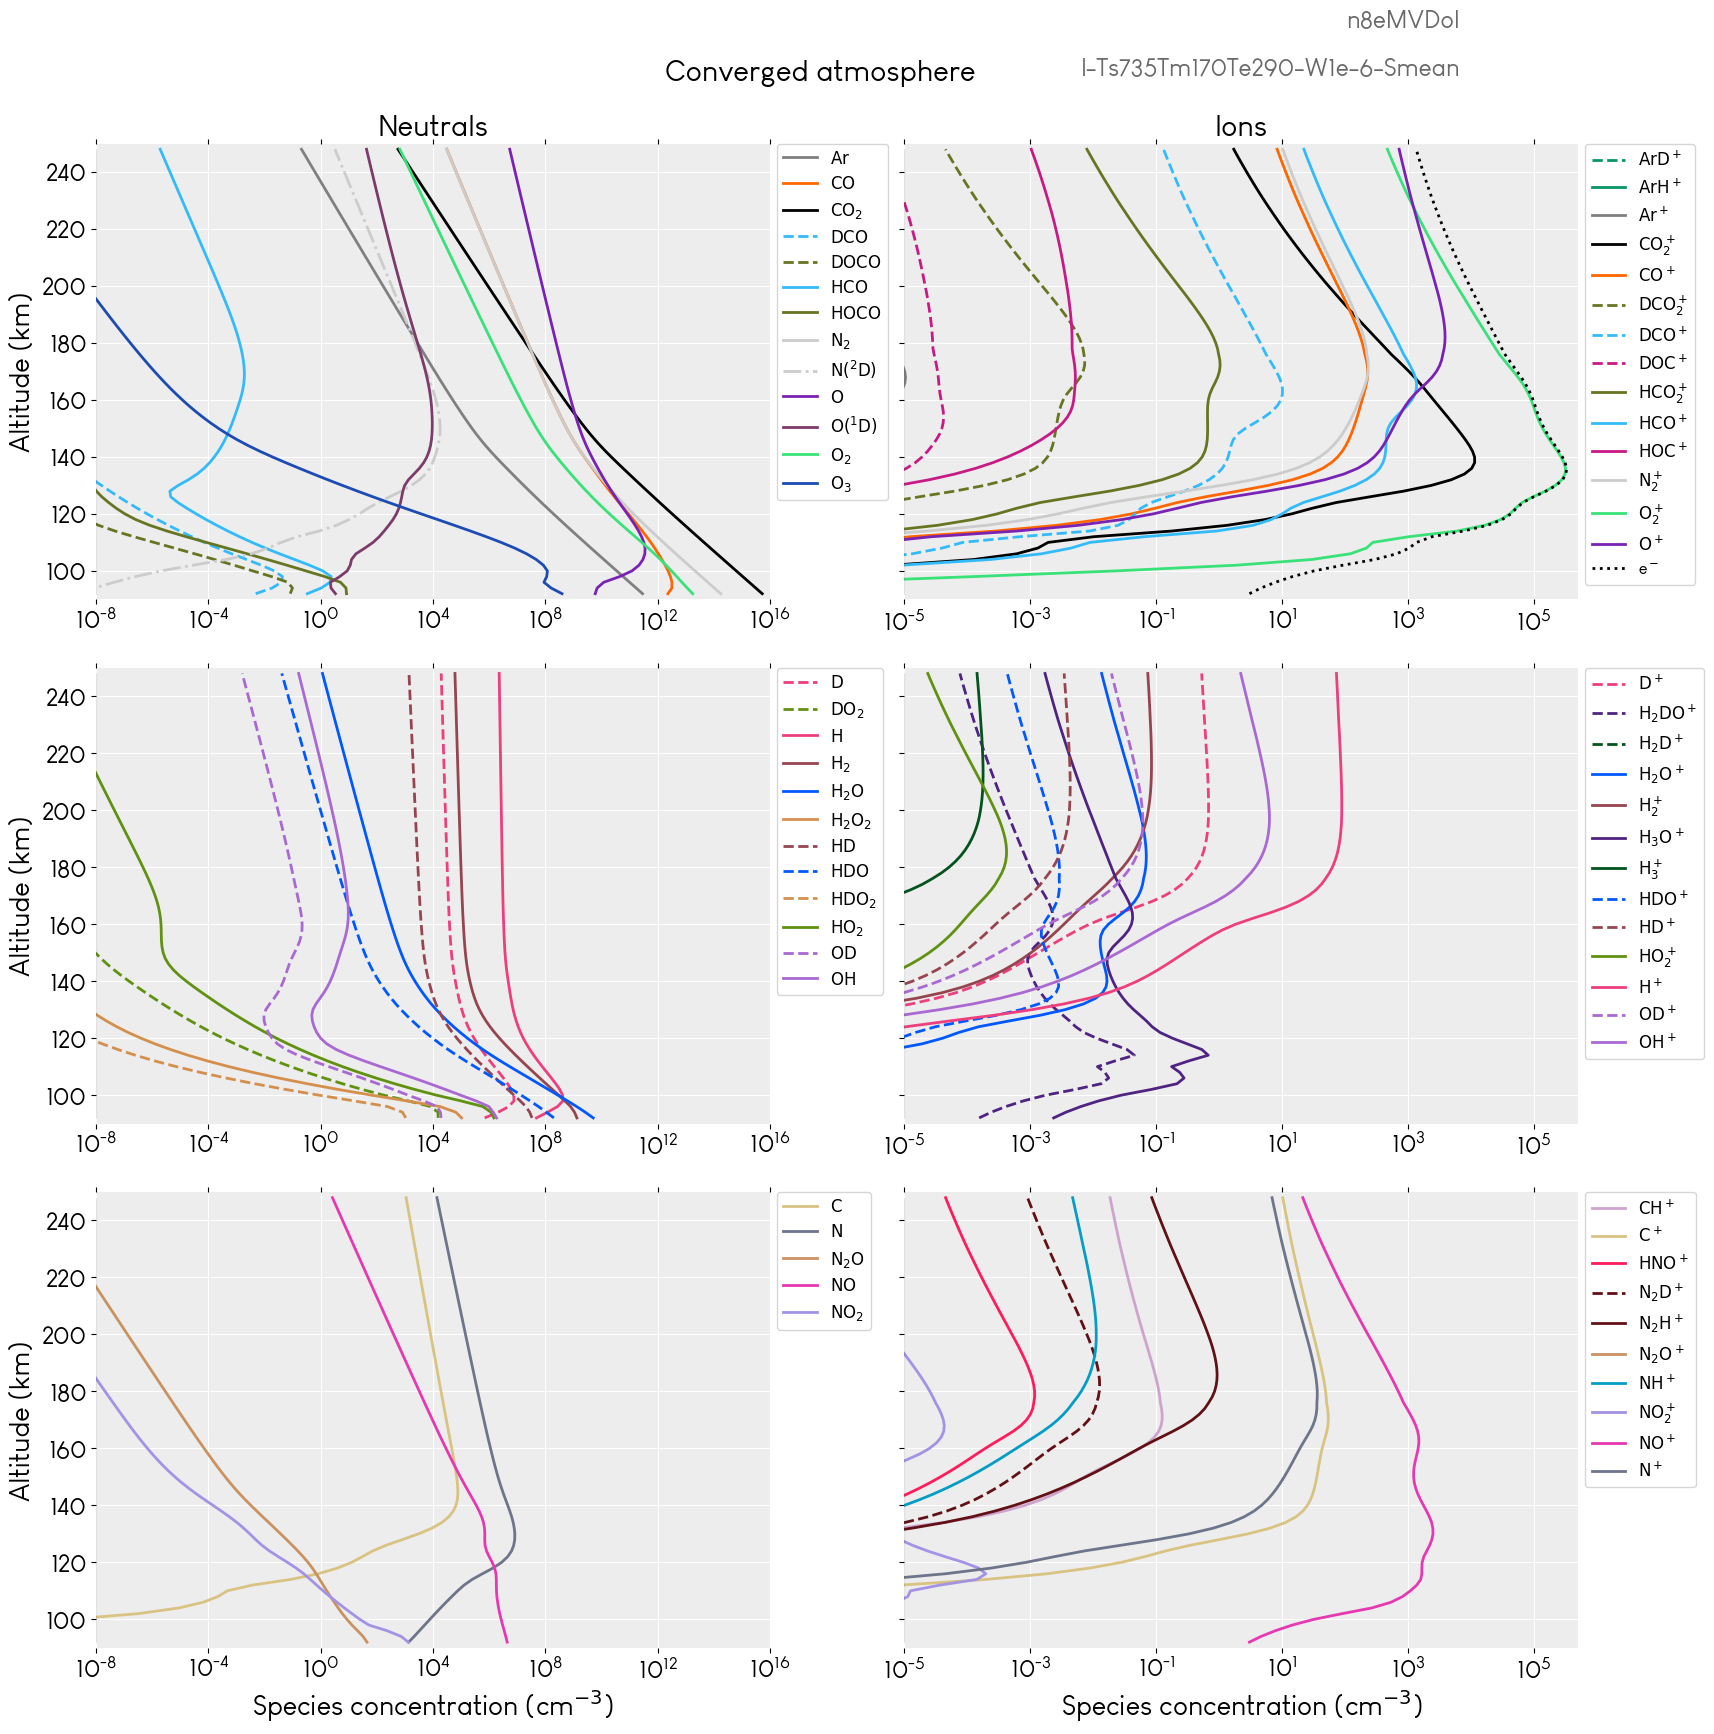

In [9]:
atm_fig_savepath = mean_folder*"final_atm_90km.png"
atm_fig = plot_atm(mean_atm, atm_fig_savepath, 1e-12, electron_density(mean_atm; e_profile_type="quasineutral", ion_species, non_bdy_layers); 
                   print_shortcodes=true, t="Converged atmosphere", 
                   xlim_1=(1e-8, 1e16), xlim_2=(1e-5, 5e5), #(3e-1,1e6),#
                   showonly=true, neutral_species, ion_species, plot_grid, speciescolor, speciesstyle, zmax,
                   hrshortcode, rshortcode,
                   ylim=[90, 250]);

In [10]:
atm_fig.savefig(atm_fig_savepath, bbox_inches="tight", dpi=300)

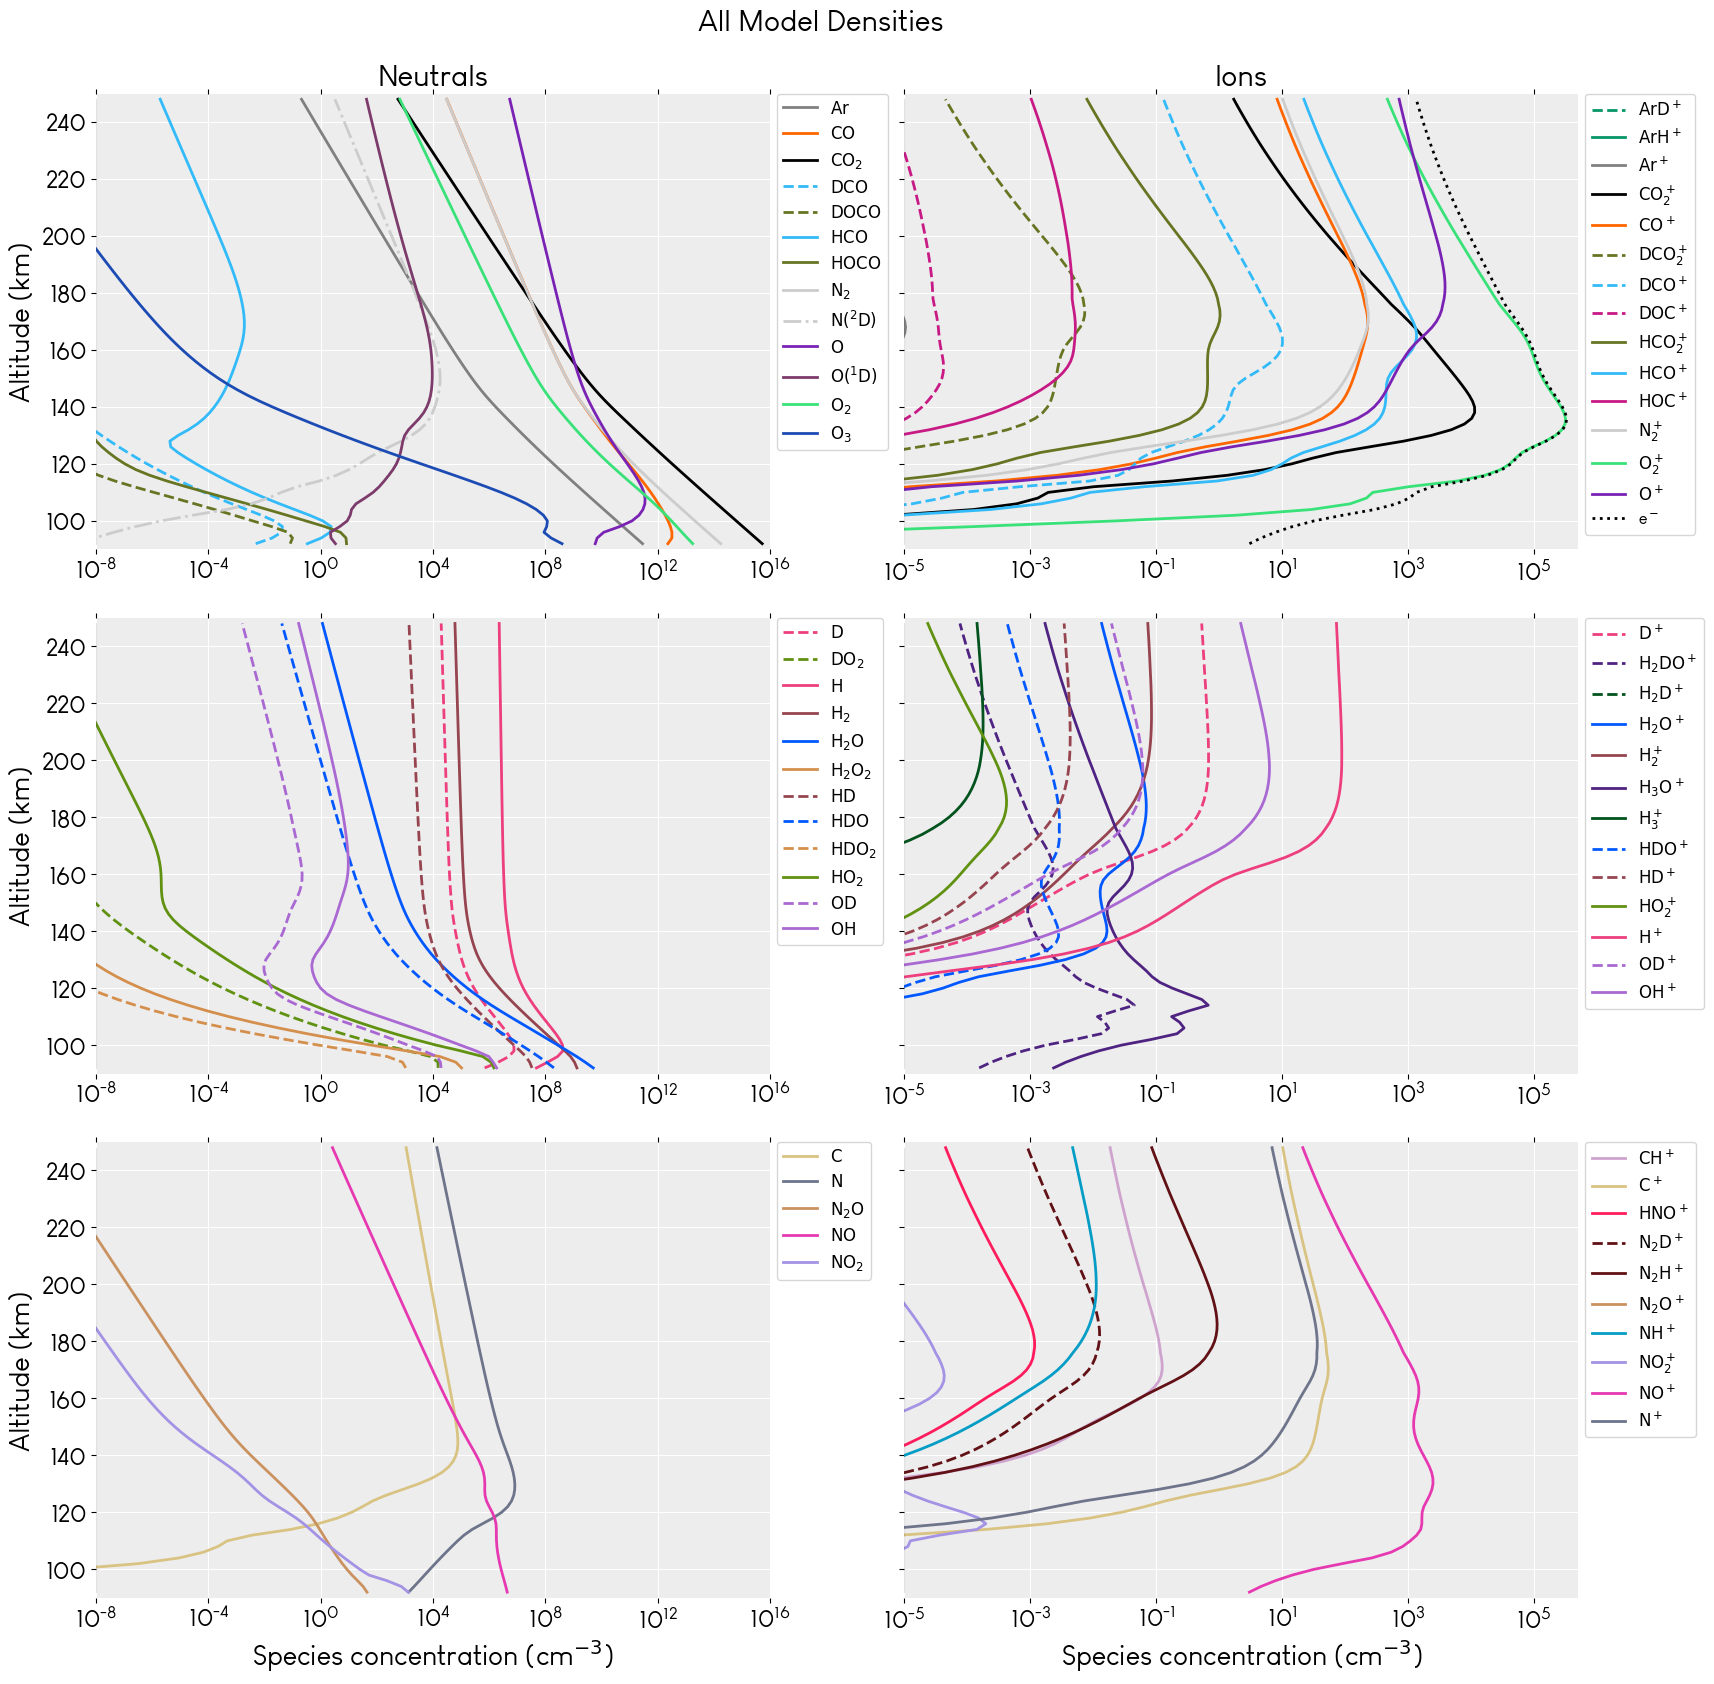

In [11]:
atm_fig = plot_atm(mean_atm, atm_fig_savepath, 1e-12, electron_density(mean_atm; e_profile_type="quasineutral", ion_species, non_bdy_layers); 
                   print_shortcodes=false, t="All Model Densities", 
                   xlim_1=(1e-8, 1e16), xlim_2=(1e-5, 5e5), #(3e-1,1e6),#
                   showonly=true, neutral_species, ion_species, plot_grid, speciescolor, speciesstyle, zmax,
                   hrshortcode, rshortcode,
                   ylim=[90, 250]);
atm_fig.savefig("/home/mike/Documents/My_Publications/2023_Venus_HCO//figures/all_species.pdf", bbox_inches="tight", dpi=300)

In [12]:
# write densities to file for bethan

eprof = electron_density(mean_atm; e_profile_type="quasineutral", ion_species, non_bdy_layers)

open(mean_folder*"output_densities_for_bethan.txt", "w") do io
    write(io, join(["alt","CO2","O","N2","CO","HCO+","e-","Te"],"\t"), "\n")
    for i in range(1,length(mean_atm[:CO2]))
        write(io, 
              string(alt[i+1]/1e5), "\t", 
              join([string(mean_atm[sp][i]) for sp in [:CO2,:O,:N2,:CO,:HCOpl]],"\t"), "\t",
              string(eprof[i]), "\t",
              string(Te[i+1]),
              "\n")
    end
end

# Essential species only

In [13]:
log10(100)

2.0

In [14]:
mike_speciescolor = Dict(
    :CO2=>"k", :Ar=>"0.5", :N2=>"0.7",
    :CO2pl=>"k", :N2pl=>"0.7",
    
    :O2=>"#006433", :O=>"#009E52",
    :O2pl=>"#006433", :Opl=>"#009E52",
    
    :OHpl=>"#8E258F", :ODpl=>"#8E258F",
    
    :H2O=>"#005493", :HDO=>"#005493",
    
    :H=>"#D51E65", :D=>"#D51E65",
    :Hpl=>"#D51E65", :Dpl=>"#D51E65",
    #:H=>"#EF6170", :D=>"#EF6170",
    #:Hpl=>"#EF6170", :Dpl=>"#EF6170",
    :H2=>"#AA1D3B", :HD=>"#AA1D3B",
    
    :HCOpl=>"#e23209", :DCOpl=>"#e23209",
    
    :CO=>"#FFAC13",
    :COpl=>"#FFAC13",
);
# this palette generated using https://coolors.co/8e258f-aa1d3b-d51e65-e23209-ffac13-005493-006433-009e52-020100

In [61]:
function plot_atm_essential(mean_atm,
        neutral_range=[5e2, 8e15],
        ion_range=[1e-3,5e5]
    )

    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["mathtext.fontset"] = "custom"
    plot_font = "Louis George Caf?" # "Gillius ADF" # "Arial" #
    rcParams["mathtext.rm"] = plot_font
    rcParams["mathtext.it"] = plot_font
    rcParams["mathtext.bf"] = plot_font
    rcParams["font.sans-serif"] = plot_font
    rcParams["font.monospace"] = "FreeMono"
    rcParams["font.size"] = 18
    rcParams["axes.titlesize"] = 18
    rcParams["axes.labelsize"]= 18
    rcParams["xtick.labelsize"] = 16
    rcParams["ytick.labelsize"] = 16
    rcParams["lines.linewidth"] = 1
    
    # Load the 3 atmospheres
    ncur = mean_atm

    # set up the overall plot -------------------------------------------------------------
    ncol = 2
    nrow = 1
    fig, ax = subplots(nrow, ncol, 
        figsize=(15, 5), 
        gridspec_kw=Dict(
            "width_ratios"=>[
                log10(neutral_range[2])-log10(neutral_range[1]),
                log10(ion_range[2])-log10(ion_range[1])], 
            "wspace"=>0.03))
    ax[1].set_xlabel(L"Neutral density (cm$^{-3}$)")
    ax[2].set_xlabel(L"Ion density (cm$^{-3}$)")
    
    for a in ax
        plot_bg(a)
        a.tick_params(which="both", labeltop=false, top=true, labelbottom=true, bottom=true, labelleft=true, width=0.5)
        a.set_ylim(90, zmax/1e5)
        a.set_yticks(100:25:250)
        a.set_xscale("log")
        a.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=18))
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=18)
        a.xaxis.set_minor_locator(locmin)
        a.tick_params(which="minor", length=2, color="0.5", width=0.5)
    end
    ax[1].set_ylabel("Altitude (km)")
    ax[2].tick_params(which="both", labelleft=false, left=false)
    
    ax[1].set_xlim(neutral_range[1], neutral_range[2])
    ax[2].set_xlim(ion_range[1], ion_range[2])
    
    # remove white gridline at 250 km  
    ax[1].get_ygridlines()[end].set_visible(false)
    ax[2].get_ygridlines()[end].set_visible(false)

    # plot the neutrals ------------------------------------------------------------
    species_to_plot = [
        :CO2, :O2, :O, :CO, :N2, :Ar, 
        :H, :D, 
        :H2, :HD, 
        :H2O, :HDO,
        :O2pl, :Opl, :CO2pl, :N2pl, :COpl,
        :HCOpl, :DCOpl,
        :Hpl, :Dpl,
        :OHpl, :ODpl
    ]
    species_posdict = Dict(:CO2=>[1e12,132], :O2=>[2.5e8,135], :O=>[1e8,200], :CO=>[6e11,98], :N2=>[1e12,119], :Ar=>[1.5e9,119], 
        :H=>[1.0e6,248], :D=>[1.3e4,248], 
        :H2=>[7.0e4,248], :HD=>[8e2,248], 
        #:H2O=>[1.1e9,105], :HDO=>[1e5,105],
        :H2O=>[1.15e4,137], :HDO=>[1.15e4,110],
        :O2pl=>[7.5e4,140], :Opl=>[4.5e2,210], :CO2pl=>[1.1e4,148], :N2pl=>[1.2e1,149], :COpl=>[2.75e1,163],
        :HCOpl=>[4.5e2,140], :DCOpl=>[7e-1,140],
        :Hpl=>[7.5e1,248], :Dpl=>[2.75e-1,248],
        :OHpl=>[5e0,185], :ODpl=>[2.75e-2,185],)
    for species in species_to_plot
        col = occursin("pl", string(species)) ? 2 : 1 # set column based on neutral or ion
        lw = occursin("D", string(species)) ? 0.65 : 1.5  # set line width based on D-bearing
        la = occursin("D", string(species)) ? 0.65 : 1  # set line width based on D-bearing

        # style things
        thiscolor = mike_speciescolor[species] #get(speciescolor, species, dimcolor)
        # if thiscolor == "#38e278" # recolor O2+ (too green)
        #     thiscolor = "#51AD7B"
        # end
        # if thiscolor == "#33bbf9" # recolor HCO+ to match reaction rate plot
        #     thiscolor = "#CE000B"# "#891E06" #"#e23209"
        # end
        this_zorder = 10

        # Axes showing range of values
        ax[col].plot(ncur[species], plot_grid, 
            color=thiscolor, linewidth=lw, alpha=la,
            label=species, zorder=this_zorder)
        if species in keys(species_posdict)
            ax[col].text(species_posdict[species]..., string_to_latexstr(string(species)), 
                color=thiscolor, alpha=la,
                size=16, va="top", ha="left")
        end
    end
    
    # plot electron density
    E_prof = electron_density(mean_atm; e_profile_type="quasineutral", ion_species, non_bdy_layers);
    ax[2].plot(convert(Array{Float64}, E_prof), plot_grid, color="0.5", linewidth=1.5, dashes=(16,2), zorder=9, label=L"e$^-$")
    ax[2].text(3e4,185,L"e^-", 
                color="0.5",
                size=16, va="top", ha="left")
    
    return fig
end

plot_atm_essential (generic function with 3 methods)

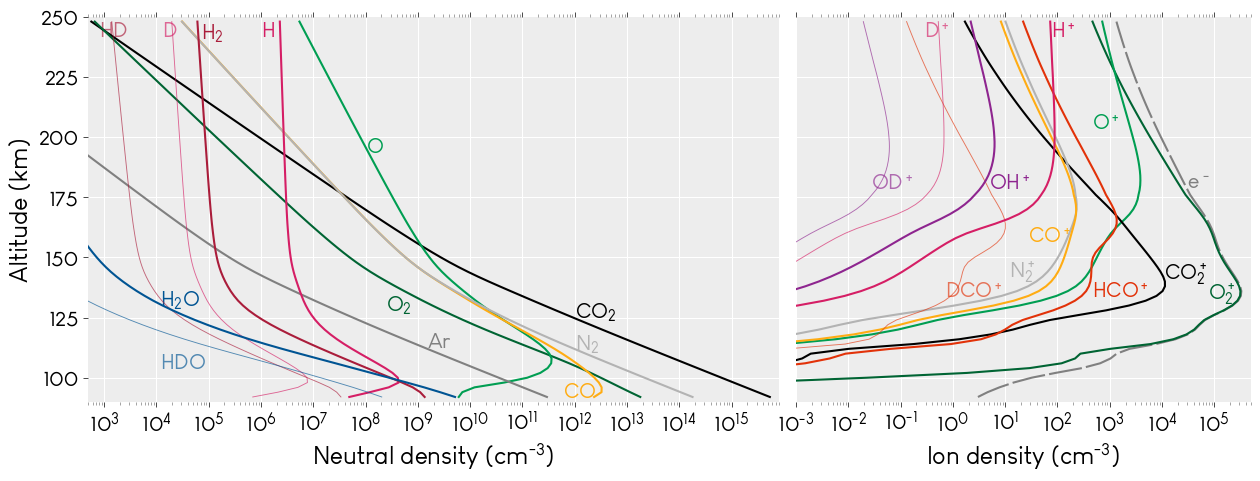

In [62]:
essential_fig = plot_atm_essential(mean_atm);
savefig("/home/mike/Documents/My_Publications/2023_Venus_HCO/figures/densities.pdf", bbox_inches="tight")

# Check to see if Brinton+1980 equilibrium calculation gives correct H density

In [17]:
# endothermic charge exchange of Hpl + O -> Opl + H
# this is the expression used in the Brinton paper, not the one used in the model
O_level_energies = [0.00, 0.02, 0.028]
kTi = (1.0/11600.0)*Ti
k1_brinton = 8.0*exp.(-0.02/kTi)./(sum([5,3,1].*exp.(-O_level_energies/kTi), dims=1))

# (rate coefficient of Hpl +CO2 -> HCOpl + O)/(rate coefficient of Opl + H -> Hpl + O) 
# we use the rates adopted in the model, not the rates from the Brinton paper
k2_brinton = 3.8e-9/6.4e-10;

In [18]:
k1_brinton

1×81 Matrix{Float64}:
 0.887939  0.887939  0.887939  0.887939  …  0.884379  0.88428  0.884177

In [19]:
model_k1 = 3.75e-10/6.4e-10 # ratio of adopted rate coefficients (Hpl + O -> H + Opl)/(Opl + H -> O + Hpl)

0.5859375

In [20]:
foxsung_Z = 1.0 .+ 0.6.*exp.(-228 ./Tn) .+ 0.2.*exp.(-326 ./Tn)
foxsung_k1 = 8/9 .* 1.0./foxsung_Z .*(exp.(-231.2 ./Ti) .+ 0.6.*exp.(-228 ./Tn) .+ 0.2.*exp.(-326 ./Tn));

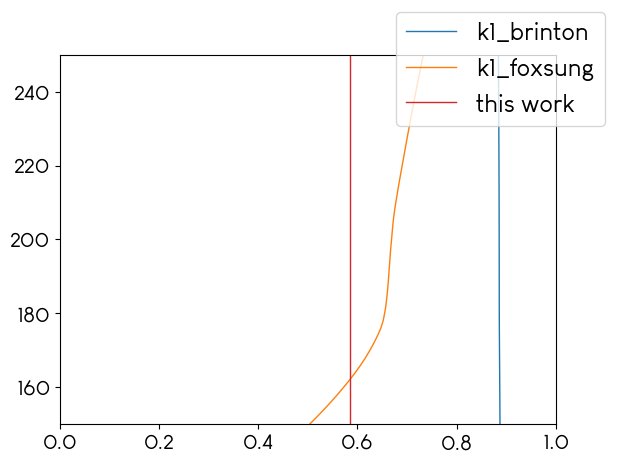

PyObject <matplotlib.legend.Legend object at 0x7f76d7476070>

In [21]:
fig, ax = subplots(1,1)
ax.plot(transpose(k1_brinton), alt/1e5, label="k1_brinton")
ax.plot(foxsung_k1, alt/1e5, label="k1_foxsung")
ax.axvline(model_k1, color="tab:red", label="this work")
ax.set_ylim(150,250)
ax.set_xlim(0, 1)
fig.legend()

The above indicates that the present model does not correctly simulate the reverse reaction of Hpl + O charge exchange; the adopted rate for this reaction is too small over most of the altitude where H+ is produced. This may also help to explain the lower O+ numbers in the present model vs past models and the atmosphere

In [22]:
nH_brinton = mean_atm[:Hpl]./mean_atm[:Opl].*(k1_brinton[2:end-1].*mean_atm[:O].*(Ti[2:end-1]./Tn[2:end-1]).^0.5 .+ k2_brinton.*mean_atm[:CO2]);
nH_foxsung = mean_atm[:Hpl]./mean_atm[:Opl].*(foxsung_k1[2:end-1].*mean_atm[:O].*(Ti[2:end-1]./Tn[2:end-1]).^0.5 .+ k2_brinton.*mean_atm[:CO2]);
nH_thismodelk1 = mean_atm[:Hpl]./mean_atm[:Opl].*(model_k1.*mean_atm[:O].*(Ti[2:end-1]./Tn[2:end-1]).^0.5 .+ k2_brinton.*mean_atm[:CO2]);

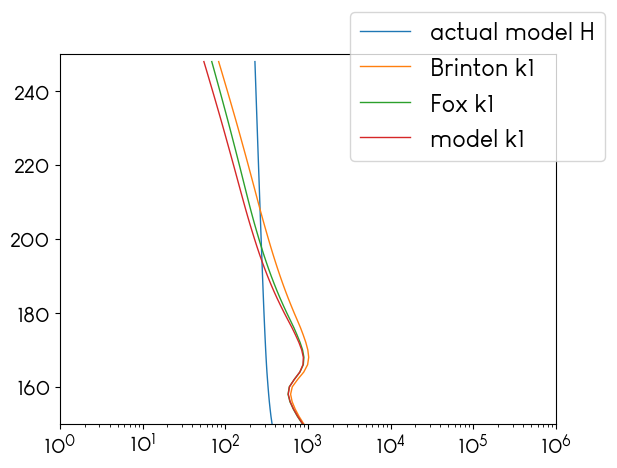

PyObject <matplotlib.legend.Legend object at 0x7f76d70e4970>

In [23]:
fig, ax = subplots(1,1)
ax.plot(mean_atm[:H]/1e4,alt[2:end-1]/1e5, label="actual model H")
ax.plot(nH_brinton/1e4,alt[2:end-1]/1e5, label="Brinton k1")
ax.plot(nH_foxsung/1e4,alt[2:end-1]/1e5, label="Fox k1")
ax.plot(nH_thismodelk1/1e4,alt[2:end-1]/1e5, label="model k1")

#ax.plot(mean_atm[:Hpl],alt[2:end-1]/1e5, label="H+")
#ax.plot(mean_atm[:O]/1e4,alt[2:end-1]/1e5, label="O")
#ax.plot(mean_atm[:Opl],alt[2:end-1]/1e5, label="O+")
ax.set_xscale("log")
ax.set_ylim(150,250)
ax.set_xlim(1,1e6)
fig.legend()

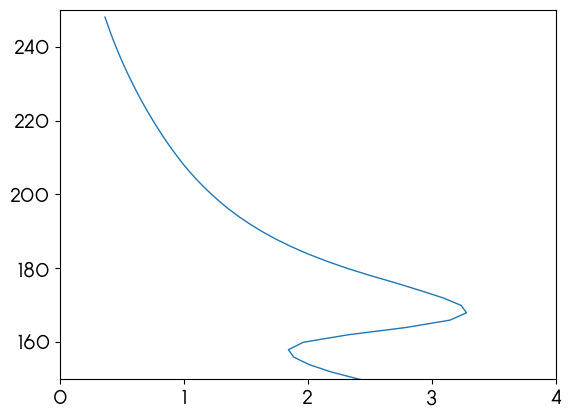

(150.0, 250.0)

In [24]:
fig, ax = subplots(1,1)
ax.plot(nH_brinton./mean_atm[:H],alt[2:end-1]/1e5)
ax.set_xlim(0,4)
#ax.set_xscale("log")
#ax.set_xlim(0.1,10)
ax.set_ylim(150,250)

These results and the model chemeq plots indicate that vertical transport can significantly perturb H densities, limiting the utility of the Brinton photochemical equilibrium argument

# Get D/H ratios in atmosphere

In [25]:
mean_atm[:D]./mean_atm[:H]

79-element Vector{Float64}:
 0.014242772578374596
 0.017452122570058286
 0.018363312251153185
 0.01803167788856482
 0.01835408471203565
 0.018825431892618743
 0.01924917427872683
 0.01955452781361432
 0.019704335664570145
 0.01967839926743029
 0.01948106939447982
 0.01913649271233328
 0.018677448434312603
 ⋮
 0.00926452754187401
 0.009200036163767963
 0.009136066060828115
 0.009072611132322278
 0.009009665460516979
 0.008947223295986372
 0.0088852790446028
 0.008823827255794822
 0.008762862612101543
 0.008702379919968228
 0.008642374101368719
 0.008582840186285877

In [26]:
(mean_atm[:D]./mean_atm[:H])/(120*(1/6420))

79-element Vector{Float64}:
 0.7619883329430408
 0.9336885574981182
 0.9824372054366953
 0.9646947670382177
 0.9819435320939071
 1.0071606062551026
 1.0298308239118854
 1.046167238028366
 1.0541819580545027
 1.0527943608075203
 1.0422372126046702
 1.0238023601098305
 0.9992434912357241
 ⋮
 0.4956522234902595
 0.49220193476158597
 0.4887795342543041
 0.4853846955792418
 0.4820171021376583
 0.47867644633527084
 0.47536242888624974
 0.4720747581850229
 0.4688131497474325
 0.46557732571830013
 0.46236701442322636
 0.45918194996629436

In [27]:
(mean_atm[:HDO]./mean_atm[:H2O])

79-element Vector{Float64}:
 0.039636317249771354
 0.04143403050144575
 0.04357453791731548
 0.04623072517884433
 0.048924369808687834
 0.05132718096260047
 0.05329752067628203
 0.05480184650124347
 0.05588826317243399
 0.05664534084772896
 0.05715900639663541
 0.05749388459911776
 0.05769150265215992
 ⋮
 0.038416839439134855
 0.03815124749894475
 0.037887619871923066
 0.03762594561349737
 0.03736621348777519
 0.03710841200226107
 0.03685252943953224
 0.03659855388533876
 0.03634647325349974
 0.036096275308802904
 0.035847947688018945
 0.035601477918520086

In [28]:
(mean_atm[:HDO]./mean_atm[:H2O])/(1/6420)

79-element Vector{Float64}:
 254.46515674353208
 266.0064758192817
 279.7485334291654
 296.8012556481806
 314.0944541717759
 329.520501779895
 342.17008274173065
 351.82785453798306
 358.8026495670262
 363.6630882424199
 366.9608210663993
 369.110739126336
 370.37944702686667
   ⋮
 246.63610919924577
 244.9310089432253
 243.23851957774608
 241.5585708386531
 239.8910905915167
 238.23600505451603
 236.59323900179697
 234.96271594387483
 233.3443582874683
 231.73808748251463
 230.1438241570816
 228.56148823689895

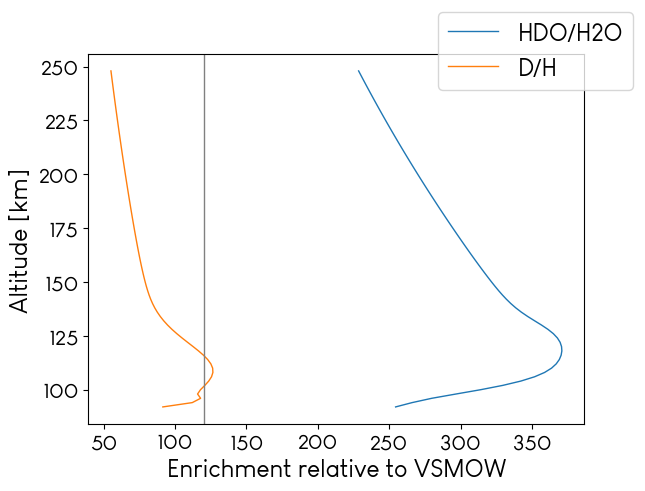

PyObject <matplotlib.legend.Legend object at 0x7f76dd832c70>

In [29]:
fig, ax = subplots(1,1)
ax.plot((mean_atm[:HDO]./mean_atm[:H2O])/(1/6420), alt[2:end-1]/1e5, label="HDO/H2O")
ax.plot((mean_atm[:D]./mean_atm[:H])/(1/6420), alt[2:end-1]/1e5, label="D/H")
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("Enrichment relative to VSMOW")
ax.axvline(120, color="0.5")
fig.legend()
#ax.set_xlim(0,4)
#ax.set_xscale("log")
#ax.set_xlim(0.1,10)
#ax.set_ylim(150,250)

These results indicate that HDO/H2O is expected to be about 5x as enriched in D as the atomic species, potentially resolving the discrepancy between remote sensing and in-situ measurements of water D/H and the Bertaux&Clarke1989 remote sensing measurement of very little thermospheric D.

# Get D+/H2+ ratios

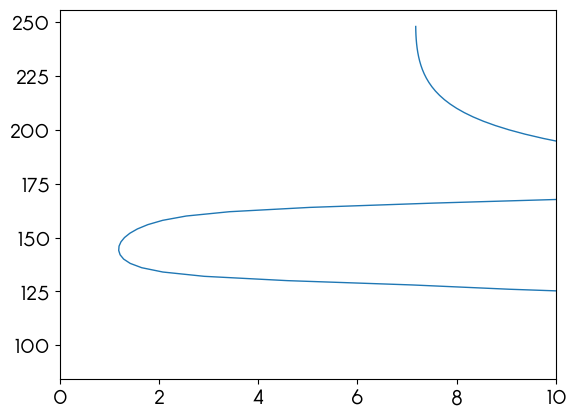

(0.0, 10.0)

In [30]:
fig, ax = subplots(1,1)
ax.plot((mean_atm[:Dpl]./mean_atm[:H2pl]),alt[2:end-1]/1e5)
ax.set_xlim(0,10)
#ax.set_xscale("log")

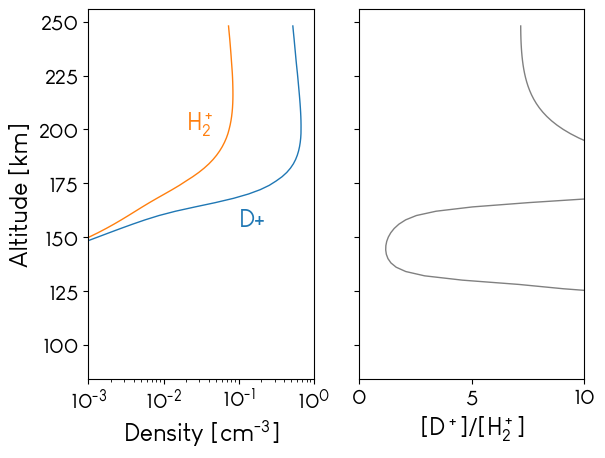

PyObject Text(0.5, 44.937499999999986, '[D$^+$]/[H$_2^+$]')

In [31]:
fig, (ax_dens, ax_ratio) = subplots(1,2,sharey=true)
ax_dens.plot(mean_atm[:Dpl],alt[2:end-1]/1e5)
ax_dens.plot(mean_atm[:H2pl],alt[2:end-1]/1e5)
#ax.set_xlim(0,10)
ax_dens.set_xscale("log")
ax_dens.set_xlim(1e-3,1)
ax_dens.set_ylabel("Altitude [km]")
ax_dens.set_xlabel("Density [cm"*L"^{-3}"*"]")
ax_dens.text(0.1,155,"D+", color="tab:blue")
ax_dens.text(0.02,200,L"\mathrm{H}_2^+", color="tab:orange")

ax_ratio.plot(mean_atm[:Dpl]./mean_atm[:H2pl],alt[2:end-1]/1e5, color="gray")
ax_ratio.set_xlim(0,10)
ax_ratio.set_xlabel("[D"*L"^+"*"]/"*"[H"*L"_2^+"*"]")

## H and D ion detail

In [32]:
ions_to_plot = [:HDpl, :H2Dpl, :H2DOpl, :HDOpl, :Dpl, :DCO2pl, :DCOpl, :ArDpl, :N2Dpl, :ODpl,
                :H2pl, :H3pl,  :H3Opl,  :H2Opl, :Hpl, :HCO2pl, :HCOpl,  :ArHpl, :N2Hpl, :OHpl]#, :NOpl, :HOCpl,
panel_groups = Dict(1=>[:H2Dpl, :H3pl,  :HDOpl, :H2Opl, :Dpl, :Hpl, :H2DOpl, :H3Opl, :ODpl, :OHpl,  ], 
                    2=>[:ArDpl, :ArHpl, :N2Dpl, :N2Hpl,  :DCOpl, :HCOpl,  :DCO2pl, :HCO2pl, :HOCpl, :H2pl, :HDpl, :NOpl]) # :DOCpl,
axes_by_sp = Dict()
for k in keys(panel_groups)
    for sp in panel_groups[k]
        axes_by_sp[sp] = k
    end
end

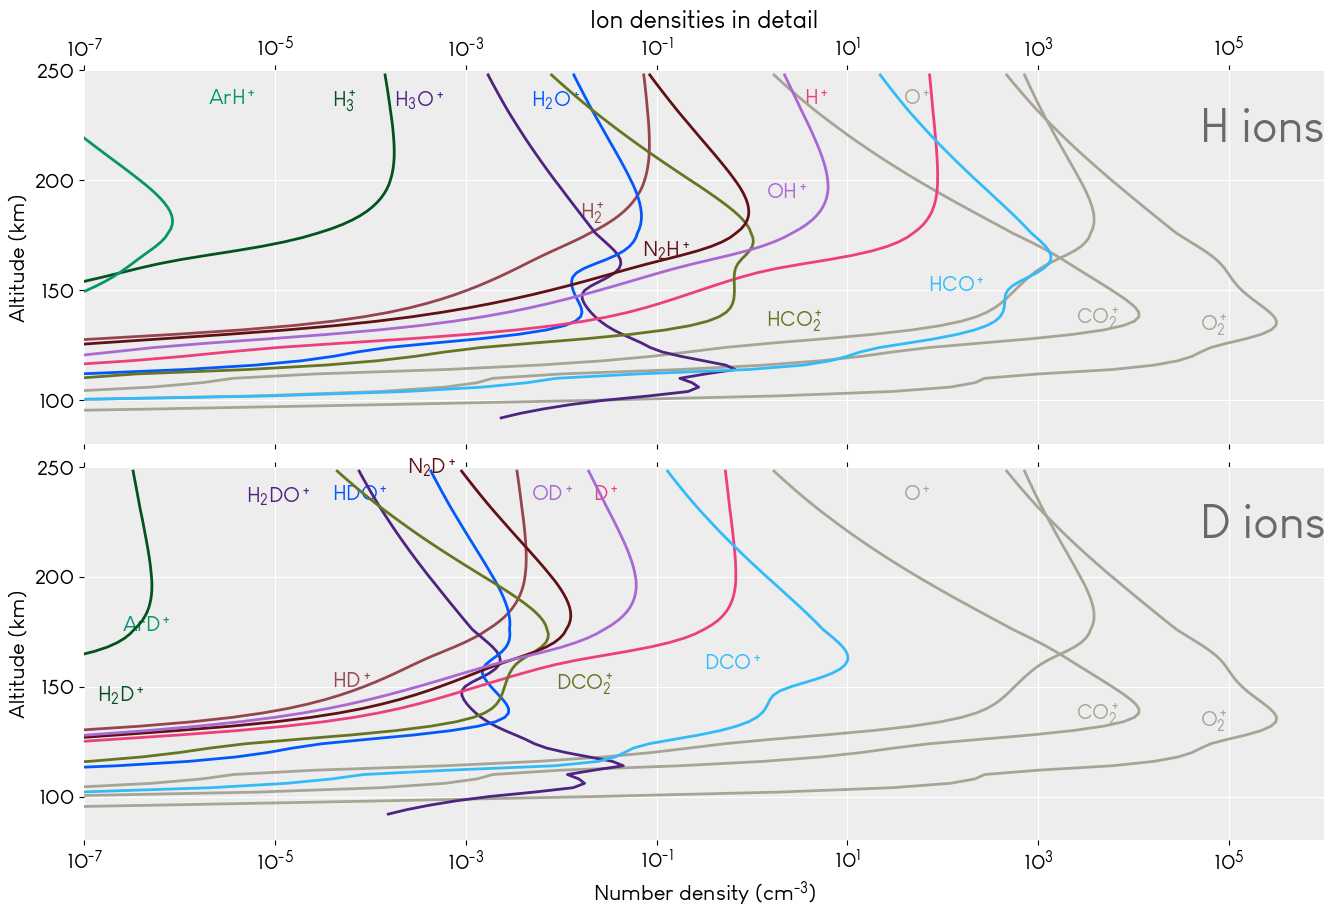

In [33]:
plot_ion_ranges_wide_2panel(ions_to_plot, mean_folder, all_result_plot_folder; extra_fn="_densities", 
                 xL = [1e-7; 1e6],    
                 posdict = Dict(:ArHpl => [0.1, 0.95], :Hpl => [0.58, 0.95], :HCOpl=>[0.68, 0.45], :HCO2pl => [0.55, 0.36],
                                 :H2Opl => [0.36, 0.95], :H3Opl => [0.25, 0.95], :H2pl => [0.4, 0.65], 
                                 :H3pl => [0.2, 0.95], :N2Hpl => [0.45, 0.55], :OHpl => [0.55, 0.7],
                                 :CO2pl=>[0.8, 0.37], :O2pl=>[0.9, 0.35], :Opl=>[0.66, 0.95],  
    
                                 :ArDpl => [0.03, 0.6], :Dpl => [0.41, 0.95], :DCOpl => [0.5, 0.5], :DCO2pl => [0.38, 0.45],
                                 :HDOpl => [0.2, 0.95], :H2DOpl => [0.13, 0.95], :HDpl => [0.2, 0.45], 
                                 :H2Dpl => [0.01, 0.42], :N2Dpl => [0.26, 1.03], :ODpl => [0.36, 0.95], 
                                 ))

# Escape

In [34]:
# LOad the reaction network for hot stuff cause we need that
reaction_network, hHnet, hDnet, hH2net, hHDnet = load_reaction_network("REACTION_NETWORK_VENUS.xlsx"; get_hot_rxns=true, all_species);
hHrc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hHnet]);
hDrc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hDnet]);
hH2rc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hH2net]);
hHDrc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hHDnet]);

In [35]:
esc_df = final_escape(mean_folder, "final_atmosphere.h5"; alt, all_species, dz, hHnet, hDnet, hH2net, hHDnet, hHrc, hDrc, hH2rc, hHDrc)

,EscapeType,H,D,H2,HD,Hpl,H2pl,TotalNeutralHAtomsLost
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Thermal,1214.03,5.47551e-9,0.0,0.0,0.0,0.0,1214.03
2,Nonthermal,2.43567e7,88367.6,2541.66,10.2343,0.0,0.0,2.43618e7
3,Total,2.4358e7,88367.6,2541.66,10.2343,0.0,0.0,2.4363e7


In [36]:
show(esc_df, allcols=true)


3×10 DataFrame
 Row │ EscapeType  H             D               H2       HD       Hpl      H2pl     TotalNeutralHAtomsLost  TotalNeutralDAtomsLost  TotalNeutralAtomsLost 
     │ String      Float64       Float64         Float64  Float64  Float64  Float64  Float64                 Float64                 Float64               
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Thermal     1214.03           5.47551e-9     0.0    0.0         0.0      0.0            1214.03                 1214.03                3642.08
   2 │ Nonthermal     2.43567e7  88367.6         2541.66  10.2343      0.0      0.0               2.43618e7               2.44502e7              7.32623e7
   3 │ Total          2.4358e7   88367.6         2541.66  10.2343      0.0      0.0               2.4363e7                2.44514e7              7.32659e7

## Fractionation

In [37]:
hdo_bottom = mean_atm[:HDO][1]
h2o_bottom = mean_atm[:H2O][1]

5.134699500716717e9

In [38]:
fractionation_factor(esc_df, h2o_bottom, hdo_bottom)

0.183041023632654

In [39]:
fractionation_factor(esc_df, h2o_bottom, hdo_bottom; ftype="thermal")

2.2757935179778023e-10

In [40]:
fractionation_factor(esc_df, h2o_bottom, hdo_bottom; ftype="nonthermal")

0.1830501451413846

## Top mechanisms of escape

In [41]:
using Latexify

In [42]:
mike_reaction_colors = Dict(
    "HCOpl + E --> CO + H" => "#E23209",
    "DCOpl + E --> CO + D" => "#E23209",
    
    "Hpl + H --> H + Hpl" => "#D51E65", #"#FF7072", #
    "Dpl + H --> D + Hpl" => "#D51E65", #"#FF7072", #
    
    "OHpl + O --> O2pl + H" => "#8E258F",
    "ODpl + O --> O2pl + D" => "#8E258F",
    
    "CO2pl + H2 --> HCO2pl + H" => "#779BE7", #"#332288",
    "CO2pl + HD --> HCO2pl + D" => "#779BE7", #"#332288",
    
    "Hpl + O2 --> O2pl + H" => "#1B998B", #"#44AA99",
    "Dpl + O2 --> O2pl + D" => "#1B998B", #"#44AA99",
);
# colors from https://coolors.co/e23209-d51e65-8e258f-1b998b-779be7

In [43]:
function plot_top5_lineandbar(total_dfs_H, total_dfs_D, by_alt_dfs_H, by_alt_dfs_D) 
    #=
    Input:
        sp: H or D usually
        total_dfs: Array of dataframes of total fluxes by reaction
        by_alt_dfs: Array of dataframes containing production profiles by altitude and by reaction
    Output: 
        Plot of the production profiles of the 5 reactions that produce the most flux
        of hot H and D.
    =#
    
    # Generate colors
    colordf = DataFrame(XLSX.readtable("IMPORTANT_RXN_COLORS.xlsx", "Sheet1"));

    # make labels not suck
    format_scin(n) = @sprintf "%.2E" n
    
    rcParams = PyCall.PyDict(matplotlib."rcParams")
    plot_font = "Louis George Caf?" # "Gillius ADF" # 
    rcParams["mathtext.rm"] = plot_font
    rcParams["mathtext.it"] = plot_font
    rcParams["mathtext.bf"] = plot_font
    rcParams["font.sans-serif"] = plot_font
    rcParams["font.monospace"] = "FreeMono"
    rcParams["font.size"] = 16
    rcParams["axes.labelsize"]= 18
    rcParams["xtick.labelsize"] = 16
    rcParams["ytick.labelsize"] = 16
    
    
    # Set up the figure dimensions
    fig, ax = subplots(1, 2, figsize=(15, 5), gridspec_kw=Dict("wspace"=>0.525))
    
    println(size(ax))
    
    # SET UP THE REACTION RATE SET -----------------------------------------------------
  
    # all panels
    plot_bg(ax[1])
    # ax[1].text(1.07, title_y[i], coltitle, transform=ax[i, 1].transAxes, size=20)
    ax[1].tick_params(which="both", labeltop=false, labelbottom=true, top=true, width=0.5)
    
    ax[1].set_xlabel(L"Escaping atom production rate (cm$^{-3}$ s$^{-1}$)")
    ax[1].set_xscale("log")
    ax[1].set_xlim(1e-4, 1e1) # H plot limits
    ax[1].xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=10)
    ax[1].xaxis.set_minor_locator(locmin)
    #ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
    #ax[1].xaxis.set_minor_locator(matplotlib.ticker.LogLocator())
    #ax[1].get_xaxis().get_major_formatter().labelOnlyBase = false
    ax[1].tick_params(which="minor", length=2, color="0.5", width=0.5)
    #ax[1].grid(zorder=-5, color="white", which="both")
    
    ax[1].set_ylabel("Altitude (km)")
    ax[1].set_ylim(125, 250)
    ax[1].set_yticks(125:25:250)
    
    #remove top and bottom gridline
    ax[1].get_ygridlines()[1].set_visible(false)
    ax[1].get_ygridlines()[end].set_visible(false)
    
    #ax[1].set_title("Production mechanisms", size=16)
    
    # color set
    # H is first column, D second column
    H_colororder = []
    H_colororder_dark = []
    D_colororder = []
    D_colororder_dark = []
    # Plot the H reactions
    for row in eachrow(total_dfs_H)[1:5]
        # thiscol = colordf[in([row.Rxn]).(colordf."H reaction"), :]."Color"[1]
        thiscol = mike_reaction_colors[row.Rxn]
        push!(H_colororder, thiscol)
        # push!(H_colororder_dark, colordf[in([row.Rxn]).(colordf."H reaction"), :]."Darker"[1])
        ax[1].plot(by_alt_dfs_H[!, row.Rxn], plot_grid, label=row.Rxn, linewidth=2.0, color=thiscol)
    end
    # And the D reactions
    for row in eachrow(total_dfs_D)[1:5]
        # thiscol = colordf[in([row.Rxn]).(colordf."D reaction"), :]."Color"[1]
        # thiscol_dark = colordf[in([row.Rxn]).(colordf."D reaction"), :]."Darker"[1]
        thiscol = mike_reaction_colors[row.Rxn]
        push!(D_colororder, thiscol)
        #push!(D_colororder_dark, thiscol_dark)

        ax[1].plot(by_alt_dfs_D[!, row.Rxn], plot_grid, label=row.Rxn, linewidth=0.75, alpha=0.65, #linestyle=(0, (10,4)),
                 mfc="black", mec="black", color=thiscol)
    end
    
    # add escape probability
    esc_prob = escape_probability(:H, mean_atm; all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)
    esc_prob_color = "0.2"
    ax[1].plot(esc_prob, plot_grid, label="esc prob", linewidth=1, color=esc_prob_color, dashes=(16,2))
    
    
    println(H_colororder)
    
    
    rcParams["hatch.linewidth"] = 1
    rcParams["hatch.color"] = "magenta"
    # NOW DO THE BAR CHART SET -------------------------------------------------------------------------
    # Make ticklabels
    H_ticklbls = ["$(string_to_latexstr(H_i))" for H_i in total_dfs_H[1:5, :].Rxn]
    D_ticklbls = ["$(string_to_latexstr(D_i))" for D_i in total_dfs_D[1:5, :].Rxn]

    # basics
    plot_bg(ax[2])
    ax[2].tick_params(which="both", left=false, labelleft=false, top=true, width=0.5)
    ax[2].set_xlim(3e1, 3e7)
    ax[2].set_xscale("log")
    ax[2].xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=10)
    ax[2].xaxis.set_minor_locator(locmin)
    ax[2].tick_params(which="minor", length=2, color="0.5", width=0.5)
    ax[2].invert_yaxis()

    # Bars 
    barw=0.5
    ax[2].barh(collect(1:5), total_dfs_H[1:5, :].Value, height=-barw, color=H_colororder, align="edge", zorder=10)#, edgecolor=H_colororder_dark)
    ax[2].barh(collect(1:5), total_dfs_D[1:5, :].Value, height=barw, color=D_colororder, alpha=0.45, #fill=false, hatch="///",
                  align="edge", zorder=10)#, edgecolor=D_colororder)

    # Values
    esc_formatter = f->latexify(@sprintf "%.2E" f; fmt=FancyNumberFormatter("%.1e",s"\g<mantissa> \\times 10^{\g<sign_exp>\g<mag_exp>}"))
    for (i, f) in enumerate(total_dfs_H[1:5, :].Value)
        ax[2].text(f*0.9, i-barw/2, "$(esc_formatter(f))", ha="right", va="center_baseline", color="white", size=16, zorder=15)
    end
    for (i, f) in enumerate(total_dfs_D[1:5, :].Value)
        ax[2].text(f*0.9, i+barw/2, "$(esc_formatter(f))", ha="right", va="center_baseline", color="white", size=16, zorder=15)
        # ax[2].text(f*1.2, i+barw/2, "$(esc_formatter(f))", ha="left", va="center_baseline", color="black", size=16, zorder=15)
    end

    # Tick labels, but manually, to make coloring better
    reaction_label_x = ax[2].get_xlim()[1]
    for y in 1:5
        ax[2].text(reaction_label_x, y-0.25, H_ticklbls[y]*"  ", color=H_colororder[y], fontsize=16, ha="right", va="center_baseline")
        ax[2].text(reaction_label_x, y+0.25, D_ticklbls[y]*"  ", color=D_colororder[y], alpha=0.65, fontsize=16, ha="right", va="center_baseline")
    end
    
    #ax[2].set_title("Reaction contributions to escape", size=16)
    ax[2].set_xlabel(L"H & D Escape flux (cm$^{-2}$ s$^{-1}$)")
    
    # Label H and D
    ax[1].text(5e-4, 166, "D-producing", weight="light", alpha=0.65, size=16)
    ax[1].text(2e-1, 130, "H-producing", weight="heavy", size=16)
    ax[1].text(1.0, 248, "escape\nprobability\n(unitless)", color=esc_prob_color, size=16, va="top")
    
    # draw a line from the HCO+ loss curve to the label
    ax[1].annotate( 
        text="", 
        xy=(6.5e-2,0.85), xycoords=ax[2].transData,
        xytext=(3e0,172), textcoords=ax[1].transData,
        arrowprops=Dict("width"=>1, "lw"=>0.0, "color"=>"#E23209", "headwidth"=>5, "headlength"=>5),
        annotation_clip=false)
    
    show()
end

plot_top5_lineandbar (generic function with 1 method)

In [44]:
# Get the Jratelist because we need it for nonthermal bcs
Jratelist = format_Jrates(mean_folder*"active_rxns.xlsx", all_species, "Jratelist"; hot_atoms=true, ions_on=true)[1];
Jratedict = Dict([j=>mean_atm[j] for j in Jratelist])

Mtot = sum([mean_atm[sp] for sp in all_species]);
# H
H_prod_by_alt = escaping_hot_atom_production(:H, hHnet, hHrc, mean_atm, Mtot; all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax);
H_prod_by_alt_df = escaping_hot_atom_production(:H, hHnet, hHrc, mean_atm, Mtot; returntype="df", all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax);
total_hot_H = nonthermal_escape_flux(hHnet, H_prod_by_alt; dz); # This is already sorted within the function here.

D_prod_by_alt = escaping_hot_atom_production(:D, hDnet, hDrc, mean_atm, Mtot; all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)
D_prod_by_alt_df = escaping_hot_atom_production(:D, hDnet, hDrc, mean_atm, Mtot; returntype="df", all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)
total_hot_D = nonthermal_escape_flux(hDnet, D_prod_by_alt; dz);

(2,)
Any["#E23209", "#D51E65", "#8E258F", "#779BE7", "#1B998B"]


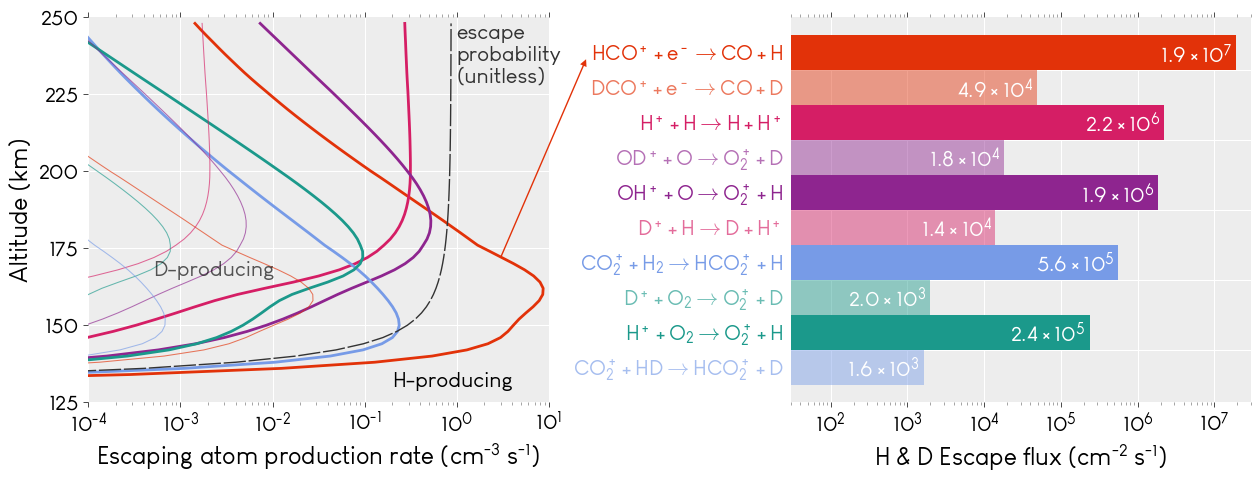

In [45]:
plot_top5_lineandbar(total_hot_H, total_hot_D, H_prod_by_alt_df, D_prod_by_alt_df)
savefig("/home/mike/Documents/My_Publications/2023_Venus_HCO/figures/escape.pdf", bbox_inches="tight")

## Venus Evolution Cartoon

In [46]:
function hydrodynamic_escape_constant_rate(t, T, W0, WT)
    return W0 + (t/T)*(WT - W0)
end

function contemporary_escape_proportional_rate(t, W0, e_folding_time)
    return W0*exp(-t/e_folding_time)
end


water_initial_inventory = 3000 # m
water_after_hydrodynamic = 100
hydrodynamic_loss_time = 1.5 # Gyr

hydrodynamic_water_loss_rate = (water_initial_inventory - water_after_hydrodynamic)/hydrodynamic_loss_time # m/Gyr


e_folding_time_old = 0.25
e_folding_time_new = 0.125
current_water_inventory = 0.03 # m
contemporary_loss_time = -e_folding_time_new*log(current_water_inventory/water_after_hydrodynamic)

solar_system_history = 4.5
time_for_ocean = solar_system_history - hydrodynamic_loss_time - contemporary_loss_time
print(time_for_ocean)

function new_water_history(t)
    if t<time_for_ocean
        return water_initial_inventory
    elseif t<time_for_ocean+hydrodynamic_loss_time
        return water_initial_inventory - hydrodynamic_water_loss_rate*(t-time_for_ocean)
    else
        return water_after_hydrodynamic*exp(-(t-time_for_ocean-hydrodynamic_loss_time)/e_folding_time_new)
    end
end
        
function old_water_history(t)
    if t<time_for_ocean
        return water_initial_inventory
    elseif t<time_for_ocean+hydrodynamic_loss_time
        return water_initial_inventory - hydrodynamic_water_loss_rate*(t-time_for_ocean)
    else
        return water_after_hydrodynamic*exp(-(t-time_for_ocean-hydrodynamic_loss_time)/e_folding_time_old)
    end
end

different_time_array = LinRange(time_for_ocean+hydrodynamic_loss_time,solar_system_history, 100)
common_time_array = LinRange(0,time_for_ocean+hydrodynamic_loss_time, 100)

old_water_history_array = [old_water_history(t) for t in different_time_array]
new_water_history_array = [new_water_history(t) for t in different_time_array];
common_water_history_array = [old_water_history(t) for t in common_time_array];

1.986033989586491

In [47]:
function plot_rates_linear(total_dfs_H, total_dfs_D, by_alt_dfs_H, by_alt_dfs_D) 
    #=
    Input:
        sp: H or D usually
        total_dfs: Array of dataframes of total fluxes by reaction
        by_alt_dfs: Array of dataframes containing production profiles by altitude and by reaction
    Output: 
        Plot of the production profiles of the 5 reactions that produce the most flux
        of hot H and D.
    =#
    
    # Generate colors
    colordf = DataFrame(XLSX.readtable("IMPORTANT_RXN_COLORS.xlsx", "Sheet1"));

    # make labels not suck
    format_scin(n) = @sprintf "%.2E" n
    
    rcParams = PyCall.PyDict(matplotlib."rcParams")
    plot_font = "Louis George Caf?" # "Gillius ADF" # 
    rcParams["mathtext.rm"] = plot_font
    rcParams["mathtext.it"] = plot_font
    rcParams["mathtext.bf"] = plot_font
    rcParams["font.sans-serif"] = plot_font
    rcParams["font.monospace"] = "FreeMono"
    rcParams["font.size"] = 16
    rcParams["axes.labelsize"]= 18
    rcParams["xtick.labelsize"] = 16
    rcParams["ytick.labelsize"] = 16
    
    Hpl_color = "tomato" # "deepskyblue"
    HCOpl_color = "deepskyblue" # "tomato"
    common_color = "0.2"
    
    
    # Set up the figure dimensions
    fig, (ax_rates, ax_water_history) = subplots(ncols=2, figsize=(14, 5), gridspec_kw=Dict("wspace"=>0.485, "width_ratios"=>[0.5,1.0]))
      
    # Rate plot
    plot_bg(ax_rates)
    ax_rates.tick_params(which="both", labeltop=false, labelbottom=true, top=false, width=0.5)
    
    ax_rates.set_xlabel("Escaping H prod. rate "*L"(cm$^{-3}$ s$^{-1}$)")
    ax_rates.set_xscale("linear")
    ax_rates.set_xlim(0, 10) # H plot limits
    ax_rates.tick_params(which="minor", length=2, color="0.5", width=0.5)
    
    ax_rates.set_ylabel("Altitude (km)")
    ax_rates.set_ylim(125, 250)
    ax_rates.set_yticks(125:25:250)
    ax_rates.set_title("Present-day H Loss", pad=10)
    
    #remove top and bottom gridline
    ax_rates.get_ygridlines()[1].set_visible(false)
    ax_rates.get_ygridlines()[end].set_visible(false)
    
    # Plot HCO+ DR and resonant charge exchange
    ax_rates.plot(by_alt_dfs_H[!, "HCOpl + E --> CO + H"], plot_grid, 
        label="HCO+ DR", linewidth=2.0, color=HCOpl_color, zorder=2)
    ax_rates.fill_betweenx(plot_grid, by_alt_dfs_H[!, "HCOpl + E --> CO + H"], 0,
        linewidth=0.0, color=HCOpl_color, alpha=0.5, zorder=2)

    ax_rates.plot(by_alt_dfs_H[!, "Hpl + H --> H + Hpl"], plot_grid, 
        label="H⁺ + H CX", linewidth=2.0, color=Hpl_color, zorder=3)
    ax_rates.fill_betweenx(plot_grid, by_alt_dfs_H[!, "Hpl + H --> H + Hpl"], 0, 
        linewidth=0.0, color=Hpl_color, alpha=0.5, zorder=3)

    ax_rates.text(0.5,232,"Past studies found that\nproton charge exchange\npowers Venus water loss,", va="top", ha="left", color=Hpl_color)
    ax_rates.text(2.6,192.8,"...but overlooked\nfar more important\n"*L"HCO$^+$ recombination.", va="top", ha="left", color=HCOpl_color)

    # Timeline plot
    plot_bg(ax_water_history)
    ax_water_history.plot(different_time_array, new_water_history_array, linewidth=2.0,  color=HCOpl_color)
    ax_water_history.plot(different_time_array, old_water_history_array, linewidth=2.0,  color=Hpl_color)
    ax_water_history.plot(common_time_array, common_water_history_array, linewidth=2.0,  color=common_color)

    
    ax_water_history.set_yscale("log")
    ax_water_history.set_ylim(0.02,5e3)
    ax_water_history.set_yticks([0.03,1.7,100,3000])
    ax_water_history.set_yticklabels(["3 cm","1.7 m", "100 m", "3 km"])
    ax_water_history.tick_params(which="minor", left=false)
    ax_water_history.set_title("Venus Water History", pad=10)
    ax_water_history.set_ylabel("Water Inventory", labelpad=45)
    ax_water_history.text(-0.23,0.5,"(global equivalent layer)",
        color="0.3",
        transform=ax_water_history.transAxes, 
        rotation=90, ha="left", va="center")

    ax_water_history.set_xlim(-0.0,4.5)
    ax_water_history.set_xticks([0.0, 2.0, 3.5, 4.5])
    ax_water_history.set_xticklabels(["0", "2", "3.5", "4.5"])
    ax_water_history.text(4.5,0.008,"(today)",ha="center",va="top")
    ax_water_history.set_xlabel("Time (Gyr)")

    ocean_label_top = 800
    ocean_label_vspacing=0.825
    ocean_label_left = 0.10
    ocean_label_hspacing=0.45
    
    ax_water_history.text(-0.08, 1850, 
        "Earth-like\nwater delivery", 
        size=12,
        va="top", ha="right", color="0.3")
    ax_water_history.text(-0.08, 65, 
        "approx. limit\nof HyD loss", 
        size=12,
        va="top", ha="right", color="0.3")
    ax_water_history.text(-0.08, 1.1,
        "too much\nleftover\nwater", 
        size=12,
        va="top", ha="right", color="0.3")
    ax_water_history.text(-0.08, 0.02, 
        "observed\nvalue",
        size=12,
        va="top", ha="right", color="0.3")
    
    ax_water_history.text(ocean_label_left, exp(log(ocean_label_top)), 
        "If Venus had Earth-like oceans\nfor 2 billion years [e.g. Way+2016],", 
        va="top", ha="left", color=common_color)
    ax_water_history.annotate("", xy=(1.0, 2200), xytext=(1.0, 900),
            arrowprops=Dict("arrowstyle"=>"-[, widthB=5.6, lengthB=0.30", "lw"=>1.25, "color"=>common_color))
    
    ax_water_history.text(ocean_label_left+ocean_label_hspacing/2, exp((1-ocean_label_vspacing/2)*log(ocean_label_top)), 
        "...and hydrodynamic loss \nrequires "*L"$\sim$"*"1.5 Gyr [Kasting&Pollack1983], ", 
        va="top", ha="left", color=common_color)
    ax_water_history.annotate("", 
        (3.15, 700), 
        (ocean_label_left+ocean_label_hspacing/2+1.85, exp((1-ocean_label_vspacing/2-0.05)*log(ocean_label_top))), 
        arrowprops=Dict(
            "edgecolor"=>common_color, "facecolor"=>common_color,
            "headlength"=>6, "headwidth"=>6, "width"=>0.0, "shrink"=>0.05, "lw"=>1.0,
            "connectionstyle"=>"angle3,angleA=0,angleB=75"))
    
    
    ax_water_history.text(ocean_label_left+ocean_label_hspacing, exp((1-ocean_label_vspacing)*log(ocean_label_top)), 
        "...published H loss rates are too slow\nto explain the observed dry atmosphere.", 
        va="top", ha="left", color=Hpl_color)
    ax_water_history.annotate("", 
        (4.35, exp((1-ocean_label_vspacing-0.04)*log(ocean_label_top))), 
        (ocean_label_left+ocean_label_hspacing/2+2.9, exp((1-ocean_label_vspacing-0.04)*log(ocean_label_top))), 
        arrowprops=Dict(
            "edgecolor"=>Hpl_color, "facecolor"=>Hpl_color, 
            "headlength"=>6, "headwidth"=>6, "width"=>0.0, "shrink"=>0.05, "lw"=>1.0))
    
    ax_water_history.text(0.95, 0.2, "By contrast, "*L"HCO$^+$ driven"*" loss is fast enough\nto support long-lived oceans on Venus.", va="top", ha="left",ma="left", color=HCOpl_color)
    
    ax_water_history.text(4.525,1.7,L"$\times$", va="center", ha="left",color="r", weight="bold", size=36)
    ax_water_history.text(4.525,0.03,L"\checkmark", va="center", ha="left",color="g", size=20)
    
    show()
end

plot_rates_linear (generic function with 1 method)

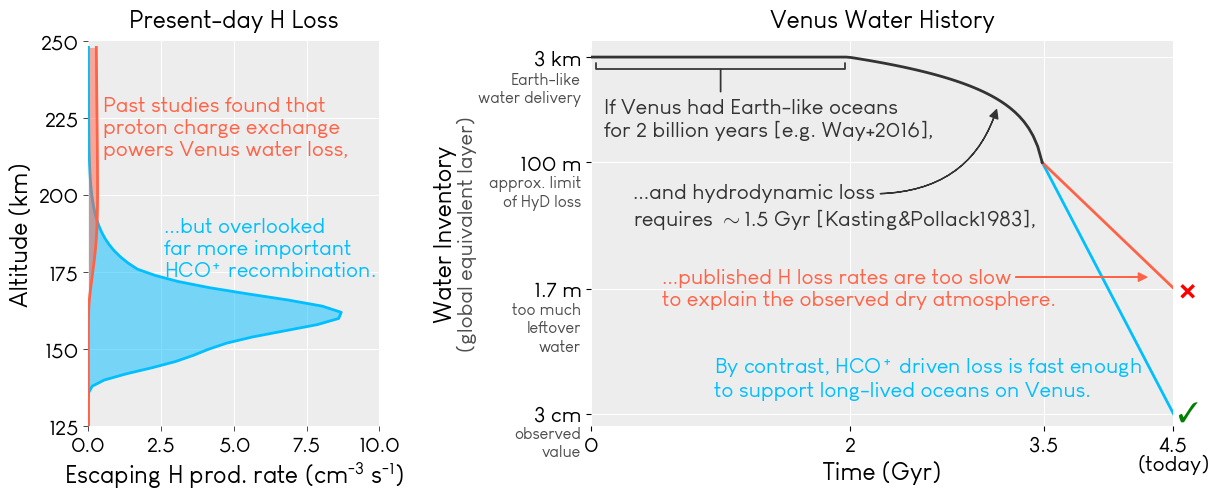

In [48]:
plot_rates_linear(total_hot_H, total_hot_D, H_prod_by_alt_df, D_prod_by_alt_df)
savefig("/home/mike/Documents/My_Publications/2023_Venus_HCO/figures/history.pdf", bbox_inches="tight")

# Model inputs figure

In [49]:
n_tot_arr = n_tot(mean_atm; all_species);
Keddy_arr = Keddy(alt, n_tot(mean_atm; all_species));

In [50]:
function mike_diffusion_coef(sp)
    A, s = diffparams(sp)
    
    return 1e17.*A.*Tn[2:end-1].^s./n_tot_arr 
end

mike_diffusion_coef (generic function with 1 method)

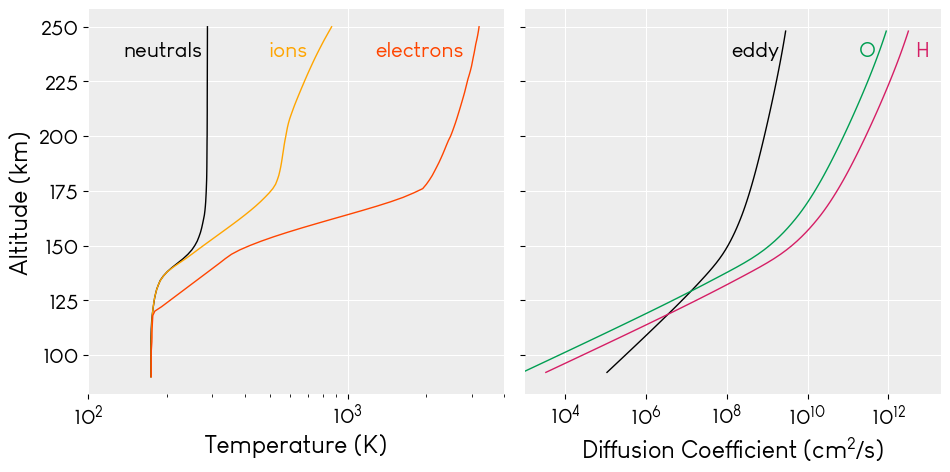

In [51]:
fig, (ax_temp, ax_diff) = subplots(ncols=2, figsize=(11,5), sharey=true, gridspec_kw=Dict("wspace"=>0.05))

plot_bg(ax_temp)
ax_temp.plot(Tn, alt/1e5, color="k")
ax_temp.text(275, 240, "neutrals", ha="right", va="center_baseline")
ax_temp.plot(Ti, alt/1e5, color="orange")
ax_temp.text(700, 240, "ions", ha="right", va="center_baseline", color="orange")
#ax_temp.text(200, 120, "will fix soon", ha="left", va="center_baseline", color="red")
ax_temp.plot(Te, alt/1e5, color="orangered")
ax_temp.text(2800, 240, "electrons", ha="right", va="center_baseline", color="orangered")
ax_temp.set_xscale("log")
ax_temp.set_xlim(100,4000)
ax_temp.set_xlabel("Temperature (K)")
ax_temp.set_ylabel("Altitude (km)")

plot_bg(ax_diff)
ax_diff.plot(Keddy_arr, alt[2:end-1]/1e5, color="k")
ax_diff.text(2e9, 240, "eddy", ha="right", va="center_baseline")
ax_diff.plot(mike_diffusion_coef(:O), alt[2:end-1]/1e5, color="#009E52")
ax_diff.text(5e11, 240, "O", ha="right", va="center_baseline", color="#009E52")
ax_diff.plot(mike_diffusion_coef(:H), alt[2:end-1]/1e5, color="#D51E65")
ax_diff.text(1e13, 240, "H", ha="right", va="center_baseline", color="#D51E65")
ax_diff.set_xscale("log")
ax_diff.set_xlim(1e3,2e13)
ax_diff.set_xlabel("Diffusion Coefficient "*L"(cm$^2$/s)")
show()
savefig("/home/mike/Documents/My_Publications/2023_Venus_HCO/figures/model_inputs.pdf")

# Examine production rates of various species to compare with other models and data

Top 5 production reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                        Value
     │ String                     Float64
─────┼───────────────────────────────────────
   1 │ CO2 --> CO2pl              2.43845e10
   2 │ COpl + CO2 --> CO2pl + CO  4.38644e9
   3 │ N2pl + CO2 --> CO2pl + N2  1.3037e9
   4 │ Npl + CO2 --> CO2pl + N    2.2119e8
   5 │ Cpl + CO2 --> CO2pl + C    1.69478e8


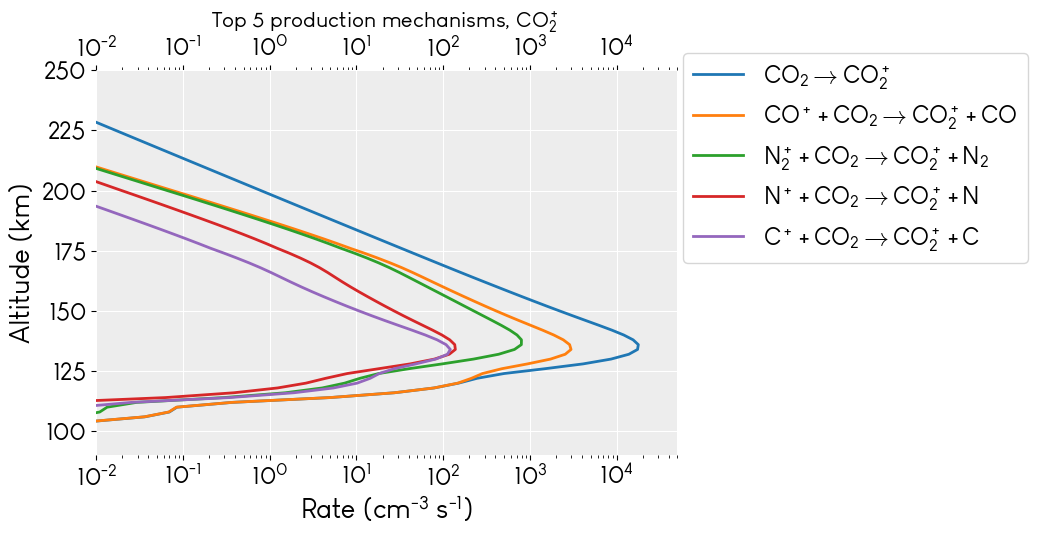

In [52]:
top_mechanisms(5, :CO2pl, mean_atm, "product"; y0=90, lowerlim=1e-2, upperlim=5e4, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 3 production reactions sorted by highest column value: 3×2 DataFrame
 Row │ Rxn                      Value
     │ String                   Float64
─────┼─────────────────────────────────────
   1 │ CO2pl + O --> Opl + CO2  1.04208e10
   2 │ CO2 --> Opl + CO         2.7394e9
   3 │ O --> Opl                2.55995e9


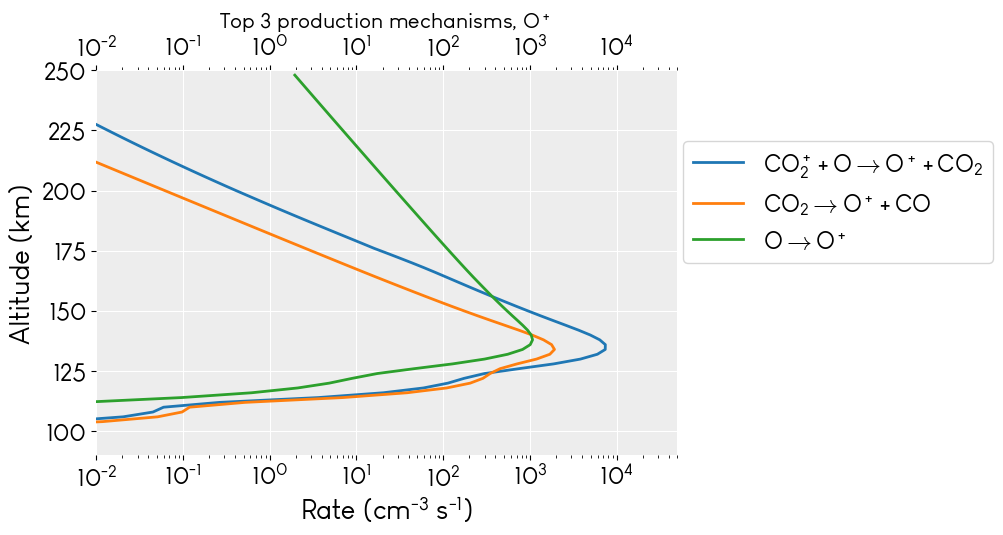

In [53]:
top_mechanisms(3, :Opl, mean_atm, "product"; y0=90, lowerlim=1e-2, upperlim=5e4, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 3 loss reactions sorted by highest column value: 3×2 DataFrame
 Row │ Rxn                      Value
     │ String                   Float64
─────┼─────────────────────────────────────
   1 │ Opl + CO2 --> O2pl + CO  1.59713e10
   2 │ Opl + H --> Hpl + O      3.78541e7
   3 │ Opl + N2 --> NOpl + N    4.13848e6


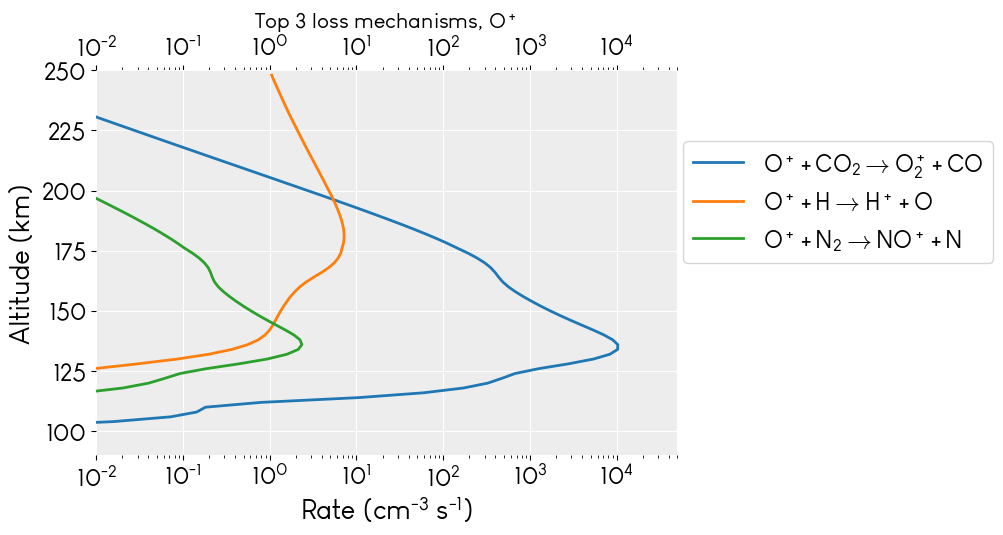

In [54]:
top_mechanisms(3, :Opl, mean_atm, "reactant"; y0=90, lowerlim=1e-2, upperlim=5e4, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 production reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                      Value
     │ String                   Float64
─────┼────────────────────────────────────
   1 │ Opl + H --> Hpl + O      3.78541e7
   2 │ CO2pl + H --> Hpl + CO2  6.01659e6
   3 │ H --> Hpl                3.78475e6
   4 │ Hpl + H --> H + Hpl      2.62905e6
   5 │ COpl + H --> Hpl + CO    1.44057e6


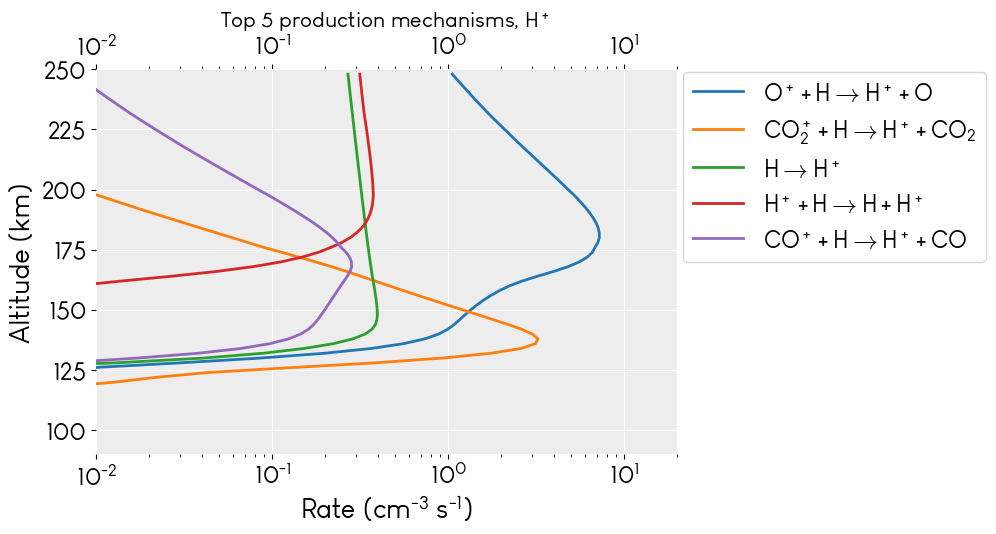

In [55]:
top_mechanisms(5, :Hpl, mean_atm, "product"; y0=90, lowerlim=1e-2, upperlim=2e1, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 loss reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                      Value
     │ String                   Float64
─────┼───────────────────────────────────────
   1 │ Hpl + CO2 --> HCOpl + O     2.80248e7
   2 │ Hpl + O --> Opl + H         2.07516e7
   3 │ Hpl + H --> H + Hpl         2.62905e6
   4 │ Hpl + O2 --> O2pl + H       3.48347e5
   5 │ Hpl + NO --> NOpl + H    1325.97


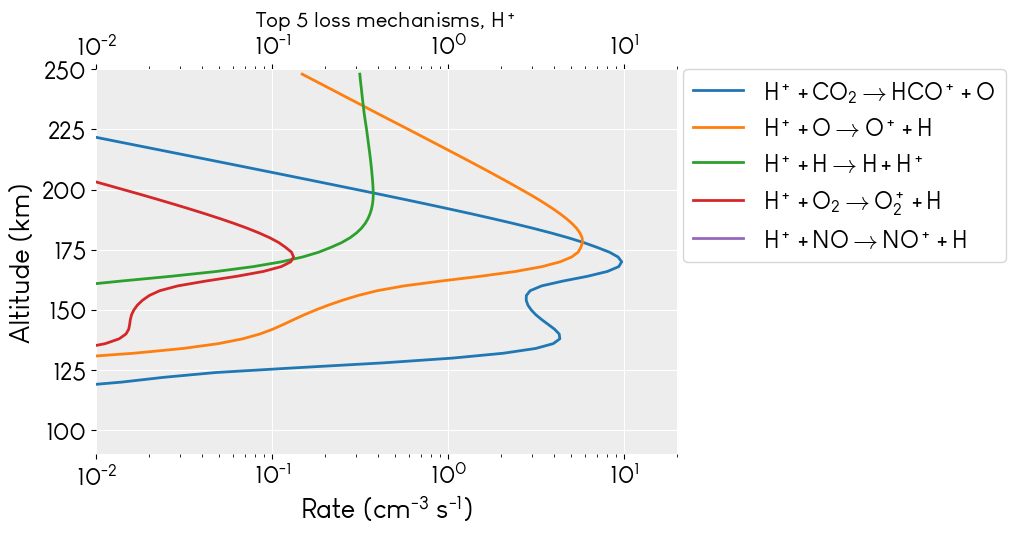

In [56]:
top_mechanisms(5, :Hpl, mean_atm, "reactant"; y0=90, lowerlim=1e-2, upperlim=2e1, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 production reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                          Value
     │ String                       Float64
─────┼────────────────────────────────────────
   1 │ CO2pl + H --> HCOpl + O      4.89596e7
   2 │ Hpl + CO2 --> HCOpl + O      2.80248e7
   3 │ HCO2pl + O --> HCOpl + O2    3.39114e6
   4 │ HCO2pl + CO --> HCOpl + CO2  2.1532e6
   5 │ OHpl + CO --> HCOpl + O      2.54892e5


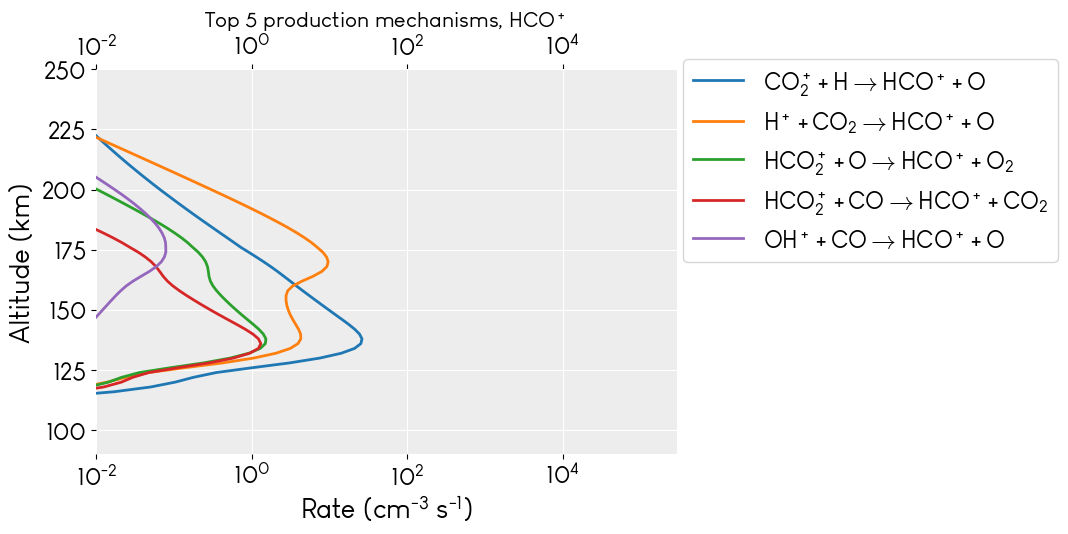

In [57]:
top_mechanisms(5, :HCOpl, mean_atm, "product"; y0=90, lowerlim=1e-2, upperlim=3e5, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 loss reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                         Value
     │ String                      Float64
─────┼───────────────────────────────────────────
   1 │ HCOpl + E --> CO + H            7.84401e7
   2 │ HCOpl + E --> OH + C            4.5494e5
   3 │ HCOpl + C --> CHpl + CO         1.88257e5
   4 │ HCOpl + H2O --> H3Opl + CO  14727.0
   5 │ HCOpl + D --> DCOpl + H      8475.26


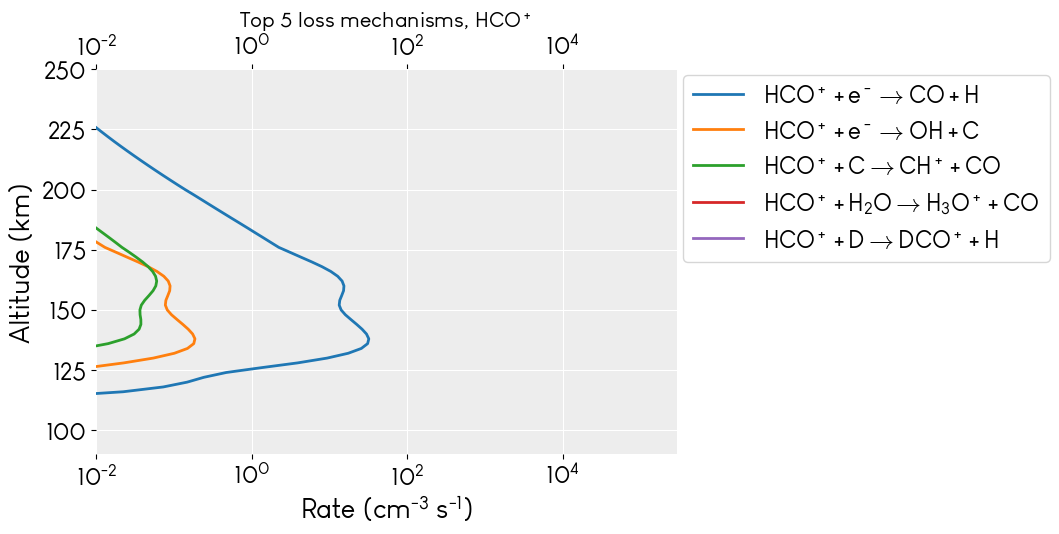

In [58]:
top_mechanisms(5, :HCOpl, mean_atm, "reactant"; y0=90, lowerlim=1e-2, upperlim=3e5, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 production reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                          Value
     │ String                       Float64
─────┼────────────────────────────────────────────
   1 │ CO2pl + H2 --> HCO2pl + H        4.80758e6
   2 │ OHpl + CO2 --> HCO2pl + O        6.00289e5
   3 │ N2Hpl + CO2 --> HCO2pl + N2      1.25958e5
   4 │ CO2pl + H2O --> HCO2pl + OH  38529.2
   5 │ H2pl + CO2 --> HCO2pl + H    23893.9


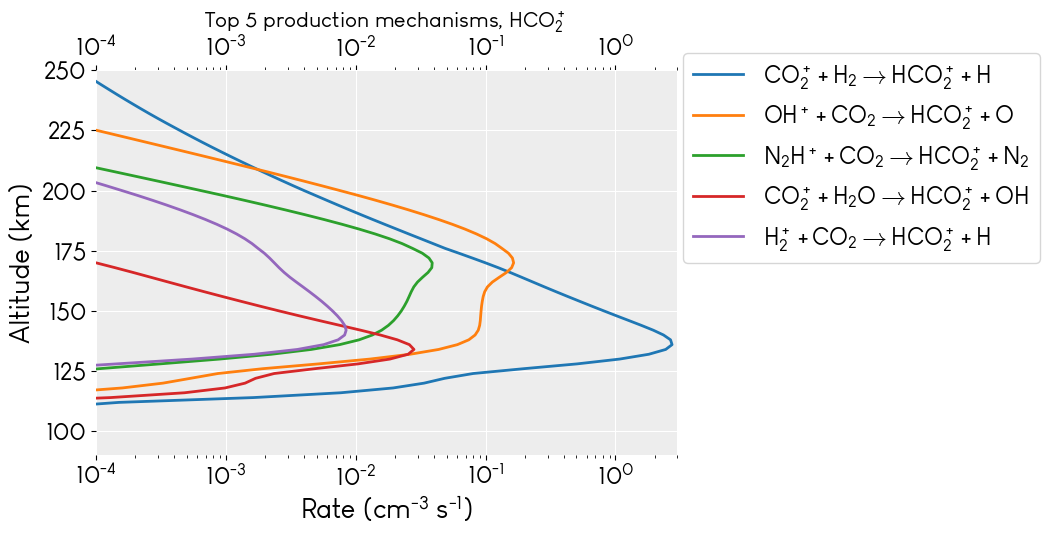

In [59]:
top_mechanisms(5, :HCO2pl, mean_atm, "product"; y0=90, lowerlim=1e-4, upperlim=3e0, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 loss reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                          Value
     │ String                       Float64
─────┼────────────────────────────────────────────
   1 │ HCO2pl + O --> HCOpl + O2        3.39114e6
   2 │ HCO2pl + CO --> HCOpl + CO2      2.1532e6
   3 │ HCO2pl + E --> CO + O + H    77232.5
   4 │ HCO2pl + E --> CO + OH       30665.9
   5 │ HCO2pl + E --> CO2 + H        5678.86


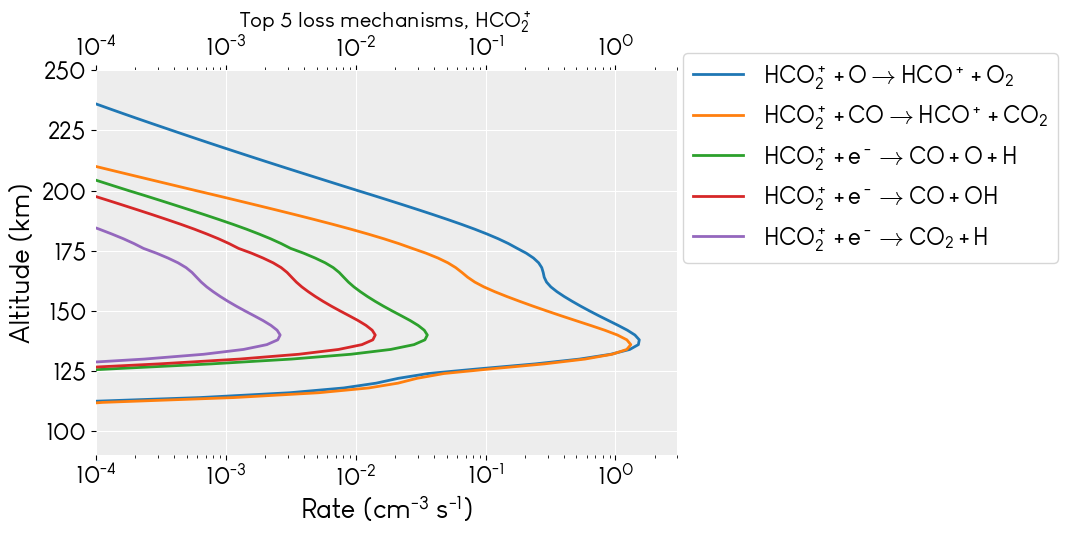

In [60]:
top_mechanisms(5, :HCO2pl, mean_atm, "reactant"; y0=90, lowerlim=1e-4, upperlim=3e0, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

## Write out new atmosphere with fewer altitudes